# Methods for Data Science: Course Work 2

## Task 1: Neural Networks, Dimensionality Reduction and Mixture Models (65 marks)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import linalg

#### 1.1 Multi-Layer Perceptron (MLP) (25 marks)  

1.1.1

Each image in the MNIST dataset represents a handwritten digit from 0 to 9, so the labels are categorical in nature. In order to use this data to train a machine learning model, we need to represent these labels as numerical values.

In [2]:
# deal with training data
original_data = pd.read_csv('MNIST_train.csv') # load the training data
X_train = original_data.to_numpy()[:,1:]/255
# get the labels
y_train = original_data.to_numpy()[:,0] 
# Convert the labels to categorical samples
y_train_categorical = np.eye(10)[y_train]

# deal with test data
original_data_test = pd.read_csv('MNIST_test.csv') # load the test data
X_test = original_data_test.to_numpy()[:,1:]/255
# get the labels
y_test = original_data_test.to_numpy()[:,0] 
# Convert the labels to categorical samples
y_test_categorical = np.eye(10)[y_test]

In [3]:
def standardise(X):
    
    # X: the input data
    # return: the standardized X
    
    # the mean and standard deviation 
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar, mu, std_filled

In [4]:
# Normalize X_train and X_test
X_train_std, mu, std_filled = standardise(X_train)
X_test_std = (X_test - mu)/std_filled

1. dense function: $h = b + xW$

2. When dealing with large input values, the exponential term $e^x$ can become extremely large, leading to numerical overflow. To avoid this issue, a modified version of the softplus function is used:
$$\text{softplus}(x) = \log(1 + e^{-|x|}) + \max(x, 0)$$
By taking the absolute value of the input $x$ and negating it, we ensure that the input to the exponential function is always non-positive, so the exponential term $e^{-|x|}$ will be between 0 and 1. This modification eliminates the risk of numerical overflow when calculating the softplus function.

3. However, when dealing with large input values, the exponential term $e^{a_i}$ can become extremely large, leading to numerical overflow. To avoid this issue, a modified version of the softmax function is used in your implementation:
$$\text{softmax}(a_i) = \frac{e^{a_i - max}}{\sum_{j} e^{a_j - max}}$$
By subtracting $max$ from each input value, we ensure that the largest input to the exponential function is always 0, and the exponential term $e^{a_i - max}$ will not cause numerical overflow.

4. I get the derivative of softplus:
$$softplus'(x) = \frac{1}{1 + e^{-x}}$$
However, when dealing with large input values, the exponential term $e^{-x}$ can become extremely small (for large positive $x$) or large (for large negative $x$), leading to numerical underflow or overflow, respectively. To avoid this issue, I separate the calculation into two cases using helper functions _positive_sigmoid and _negative_sigmoid.

Sigmoid function for positive input values ($x \geq 0$):$\sigma(x) = \frac{1}{1 + e^{-x}}$

Sigmoid function for negative input values ($x < 0$): $\sigma(x) = \frac{e^x}{1 + e^x}$

And the Sigmoid function is $softplus'(x)$

5. The output_error function computes the output error for a neural network using the kl-divergence loss and softmax activation function in the output layer.
kl divergence is : $L(y, \hat{y}) = \sum_{i=1}^{n} y_i \log\frac{y_i}{\hat{y}_i}$. Where $y$ is the ground truth label vector and $\hat{y}$ is the predicted label vector. In the context of this code, $\hat{y}$ is given by the softmax function applied to the output pre-activations $a$:
$$\hat{y}_i = \text{Softmax}(a)i = \frac{e^{a_i}}{\sum{j=1}^{n} e^{a_j}}$$
Now, we want to compute the gradient of the loss function with respect to the output pre-activations $a$:
$$\frac{\partial L}{\partial a_k} = \frac{\partial L}{\partial \hat{y}_i} \frac{\partial \hat{y}_i}{\partial a_k}$$

Using the chain rule, we can compute the derivatives as follows:

Derivative of the KL divergence loss with respect to the predicted label vector:
$\frac{\partial L}{\partial \hat{y}_i} = -\frac{y_i}{\hat{y}_i}$

Derivative of the softmax function with respect to the output pre-activations:
$\frac{\partial \hat{y}_i}{\partial a_k} = \hat{y}i(\delta{ik} - \hat{y}_k)$

Where $\delta_{ik}$ is the Kronecker delta.

Now, we can compute the gradient of the loss function with respect to the output pre-activations $a$:

$\frac{\partial L}{\partial a_k} = \sum_{i=1}^{n} \frac{\partial L}{\partial \hat{y}_i} \frac{\partial \hat{y}i}{\partial a_k} = -\sum{i=1}^{n} \frac{y_i}{\hat{y}_i} (\hat{y}i(\delta{ik} - \hat{y}_k)) = \hat{y}_k - y_k$

The following steps are performed:

Compute the partial derivative of the loss with respect to the predicted label vector:
$d_{L\hat{y}} = -\frac{y}{\text{Softmax}(a)}$

Initialize an array delta with the same shape as the output pre-activations a.

For each example in the batch, compute the partial derivative of the softmax function with respect to the output pre-activations:

$d_{\hat{y}a} = \text{softmax derivative}(a_{n, :})$

Update the gradient of the loss function with respect to the output pre-activations a:
$\delta_{n, :} = d_{L\hat{y}}[n, :] \cdot d_{\hat{y}a}$

Return the gradient of the loss function with respect to the output pre-activations a, stored in the array delta.

In [5]:
def dense(x, W, b):
    
    # x: K x h_in array of inputs
    # W: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: K x h_out output array 
    
    h = b + x @ W  ## <-- pre-activations
    return h


def softplus(x, beta=1):
    '''
    activation function for hidden layers
    Args:
        x: array of pre-activations
        beta: a coefficient before x
    returns: softplus(x) of x
    '''
    # we add this to avoid overflow
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0)

def softmax(a):
    '''
    activation function for the output layer
    Args:
        a: 10 x K array of input
    returns: 10 x K array of softmax(a)
    '''
    # we add this to avoid overflow
    exps = np.exp(a - np.max(a, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)


def output_error_mse(y_batch, y_pred):
    
    # y_batch: K x 10 array of data outputs
    # a2: array of output pre-activations
    # returns: K x 10 array of output errors 
    
    return y_pred-y_batch

def softmax_derivative(x):
        s = softmax(x).reshape(-1,1)
        return np.diagflat(s) - np.dot(s, s.T)
    
def output_error(y, a):
    """
    y: outputs, shape(K, 10)
    a: output pre-activations, shape(K, 10)
    returns: 
    delta: K x 10 array of output errors 
    """
    deri_h = -np.divide(y,softmax(a))
    
    delta4 = np.zeros(a.shape)
    for n in range(a.shape[0]):
        deri_a = softmax_derivative(a[n,:])
        delta4[n,:] = deri_h[n,:] @ deri_a
    
    return delta4


def _positive_sigmoid(x):
    return 1 / (1 + np.exp(-x))

def _negative_sigmoid(x):
    # Cache exp so you won't have to calculate it twice
    exp = np.exp(x)
    return exp / (exp + 1)

def sigmoid(x):
    positive = x >= 0
    # Boolean array inversion is faster than another comparison
    negative = ~positive

    # empty contains juke hence will be faster to allocate than zeros
    result = np.zeros(x.shape)
    result[positive] = _positive_sigmoid(x[positive])
    result[negative] = _negative_sigmoid(x[negative])

    return result


def activation_derivative(x):
    
    # a: K x 200 array of hidden layer pre-activations
    # returns: K x 200 array of diagonal elements  
    
    return sigmoid(x)



In [6]:
# Define the KL divergence loss function
def kl_divergence(y_true, y_pred):
    
    """
    Compute the KL divergence loss between the predicted and true probability distributions.
    y_true: the true probability distribution, shape (N, 10)
    y_pred: the predicted labels, shape (N, 10)
    """
    
    eps = np.finfo(float).eps  # smallest representable float value to avoid underflow
    y_true = np.maximum(y_true, eps)  # clip probabilities to avoid log(0)
    y_pred = np.maximum(y_pred, eps)
    
    return np.sum(y_true * np.log(y_true / y_pred))

def accuracy(y, y_preds):
    
    # compute the accuracy for the predict labels
    # y: categorical dataset
    # y_pred: predicted y by the model
    # returns: the accuracy for the model
    
    correct = sum([np.argmax(y[i]) == np.argmax(y_preds[i]) for i in range(len(y_preds))])
    return correct / len(y_preds)

In [7]:
def mlp(X, W,b):
    
    # define the forward function mlp to get pre-activations and post-activations 
    # X: K x 784 array of inputs
    # w: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: pre-activations and post-activations
     
    h0 = X
    a1 = dense(h0, W[0], b[0])
    h1 = softplus(a1,1)
    a2 = dense(h1, W[1], b[1])
    h2 = softplus(a2,1)
    a3 = dense(h2, W[2], b[2])
    h3 = softplus(a3,1)
    a4 = dense(h3, W[3], b[3])
    y = softmax(a4)
    
    return a1, a2, a3, a4, h0, h1, h2, h3, y

def backpropagate(delta, W, a):
    
    # delta: K x 10 array of output errors
    # W: 200 x 10 array
    # a: K x 200 array of hidden layer pre-activations
    # returns: K x 200 array of hidden layer errors
    back = activation_derivative(a) * (delta @ W.T)
    
    return back

def grads(delta1, delta2, delta3, delta4, h0, h1, h2, h3, N):
    
    # delta1: K x 200 array of hidden layer errors
    # delta2: K x 200 array of hidden layer errors
    # delta3: K x 200 array of hidden layer errors
    # delta4: K x 10 array of output errors
    # h0: K x 784 array of inputs
    # h1: K x 200 array of hidden layer post-activations
    # h2: K x 200 array of hidden layer post-activations
    # h3: K x 200 array of hidden layer post-activations
    # returns: tuple of arrays for gradients
   
    grad_W0 = h0.T @ delta1 / N
    grad_W1 = h1.T @ delta2 / N 
    grad_W2 = h2.T @ delta3 / N
    grad_W3 = h3.T @ delta4 / N
    
    grad_b0 = np.mean(delta1, axis = 0)
    grad_b1 = np.mean(delta2, axis = 0)
    grad_b2 = np.mean(delta3, axis = 0)
    grad_b3 = np.mean(delta4, axis = 0)
    
    
    return grad_W0, grad_W1, grad_W2, grad_W3, grad_b0, grad_b1, grad_b2, grad_b3
        
  

In [8]:
def batch_generator(X, y, batch_size):
    # x: K x 784 array of inputs
    # y: K x 10 array of true outputs
    # batch_size: the maximum size of a batch
    # return: each batch at a time
    n_batches = len(X) // batch_size
    for i in range(n_batches):
        start = i * batch_size
        end = (i + 1) * batch_size
        yield X[start:end], y[start:end]

The following function trains a multi-layer perceptron (MLP) using stochastic gradient descent (SGD) for classification.

In [9]:
def train_model_SGD(X, y, X_test, y_test, learning_rate, batch_size=128, epochs=40, width = 200,plot=False):
    
    '''
    X: The input training data, which is a numpy array of shape (N, 784).
    y: The target training labels, which is a numpy array of shape (N, 10) 
    X_test: The input testing data, which is a numpy array of shape (n_samples_test, 784).
    y_test: The target testing labels, which is a numpy array of shape (n_samples_test, 784).
    learning_rate: The learning rate used for stochatic gradient descent.
    batch_size: The size of the mini-batches used in stochastic gradient descent.
    epochs: The number of epochs (iterations over the entire training set) to train the model for.
    
    returns: the learned parameters W and b lists, the training and testing losses, and the training and testing accuracies.
    '''
      
    # Initialization: create the parameters
    dim = 28 * 28
    nclass = 10
    var0 = 2. / (dim + width)
    W0 = np.random.randn(dim, width) * np.sqrt(var0)
    b0 = np.zeros(width)

    var1 = 2. / (width + width)
    W1 = np.random.randn(width, width) * np.sqrt(var1)
    b1 = np.zeros(width)

    var2 = 2. / (width + width)
    W2 = np.random.randn(width, width) * np.sqrt(var2)
    b2 = np.zeros(width)

    var3 = 2. / (width + nclass)
    W3 = np.random.randn(width, nclass) * np.sqrt(var3)
    b3 = np.zeros(nclass)

    W_l = [W0, W1, W2, W3]
    b_l = [b0, b1, b2, b3]  
    W = []
    b = []
    loss_train_list = []
    acc_train = []
    loss_test_list = []
    acc_test = []
    activation1 = []
    for n in range(epochs):
        
        batch_gen = batch_generator(X, y, batch_size)
        for X_batch, y_batch in batch_gen:
            
            N = len(X_batch)
            # Forward propagation through the MLP
            a1, a2, a3, a4, h0, h1, h2, h3, y_pred = mlp(X_batch, W_l, b_l)
            
            # backward propagation step to gain delta4 to delta1
            delta4 = output_error(y_batch, a4)
            delta3 = backpropagate(delta4, W3, a3)
            delta2 = backpropagate(delta3, W2, a2)
            delta1 = backpropagate(delta2, W1, a1)
            grad_W0, grad_W1, grad_W2, grad_W3, grad_b0, grad_b1, grad_b2, grad_b3 = grads(delta1, delta2, delta3, delta4, h0, h1, h2, h3, N)
            
            # gradient descent here for W and b: Update weights and biases using the computed gradients and learning rate
            W0 = W0 - learning_rate * grad_W0
            W1 = W1 - learning_rate * grad_W1
            W2 = W2 - learning_rate * grad_W2
            W3 = W3 - learning_rate * grad_W3
            b0 = b0 - learning_rate * grad_b0
            b1 = b1 - learning_rate * grad_b1
            b2 = b2 - learning_rate * grad_b2
            b3 = b3 - learning_rate * grad_b3
            
            # Update the lists of weights and biases
            W_l = [W0, W1, W2, W3] 
            b_l = [b0, b1, b2, b3] 
        
        
        W_l = [W0, W1, W2, W3] 
        b_l = [b0, b1, b2, b3]  
        
        # Compute predictions for the training and testing data
        y_pred= mlp(X, W_l, b_l)[-1]
        y_pred_test = mlp(X_test, W_l, b_l)[-1]
        activations = mlp(X_test[:batch_size], W_l, b_l)[-4]
        # Store the first hidden layer's activations for visualization later
        activation1.append(activations)
        
        W.append(W_l)
        b.append(b_l)

        # Calculate the loss and accuracy for the training and testing data
        loss_train_list.append(kl_divergence(y, y_pred)/6000)
        acc_train.append(accuracy(y, y_pred))
        loss_test_list.append(kl_divergence(y_test, y_pred_test)/1000)
        acc_test.append(accuracy(y_test, y_pred_test))
        
    if plot == True:  
        # Plot histogram of activations for the first hidden layer on the first batch of the test data
        plt.figure()
        plt.hist(activations.flatten(), bins=200, label="Activations")
        plt.xlabel("Activation value")
        plt.ylabel("Frequency")
        plt.legend()
        plt.title(f"Epoch {epochs}, Batch {1}, Activation without dropout")
        plt.show()
        
    return W, b, loss_train_list, loss_test_list, acc_train, acc_test, activation1

Here I use different learning rate and store there losses for train and test in the final epoch.

In [10]:
lr = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
loss_train_final = []
loss_test_final = []
loss_7_train = []
loss_7_test = []
acc_7_train = []
acc_7_test = []
for i in lr:
    w, b , loss_train_list, loss_test_list, acc_train, acc_test, activation1= train_model_SGD(X_train_std, y_train_categorical, X_test_std, y_test_categorical, learning_rate = i, batch_size=128, epochs=40, width = 200)
    loss_train_final.append(loss_train_list[-1])
    loss_test_final.append(loss_test_list[-1])
    loss_7_train.append(loss_train_list)
    loss_7_test.append(loss_test_list)
    acc_7_train.append(acc_train)
    acc_7_test.append(acc_test)

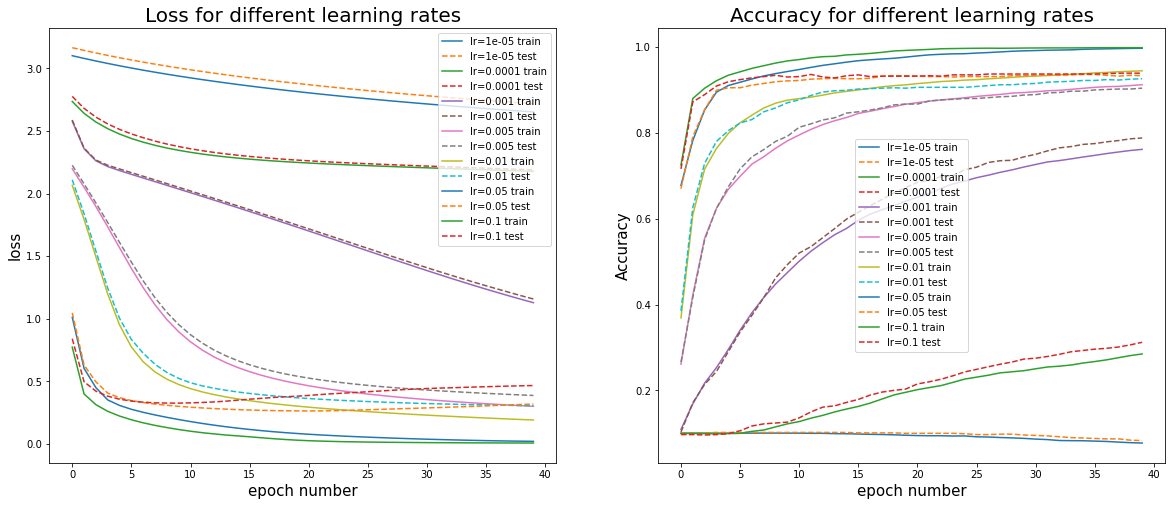

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

learning_rates = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]

for i, lr in enumerate(learning_rates):
    ax1.plot(range(len(loss_7_train[i])), loss_7_train[i], label=f'lr={lr} train')
    ax1.plot(range(len(loss_7_test[i])), loss_7_test[i], '--', label=f'lr={lr} test')
    
    ax2.plot(range(len(acc_7_train[i])), acc_7_train[i], label=f'lr={lr} train')
    ax2.plot(range(len(acc_7_test[i])), acc_7_test[i], '--', label=f'lr={lr} test')

ax1.set_xlabel('epoch number', size=15)
ax1.set_ylabel('loss', size=15)
ax1.set_title('Loss for different learning rates', size=20)
ax1.legend(fontsize=10)

ax2.set_xlabel('epoch number', size=15)
ax2.set_ylabel('Accuracy', size=15)
ax2.set_title('Accuracy for different learning rates', size=20)
ax2.legend(fontsize=10)

plt.show()


0.1
0.01


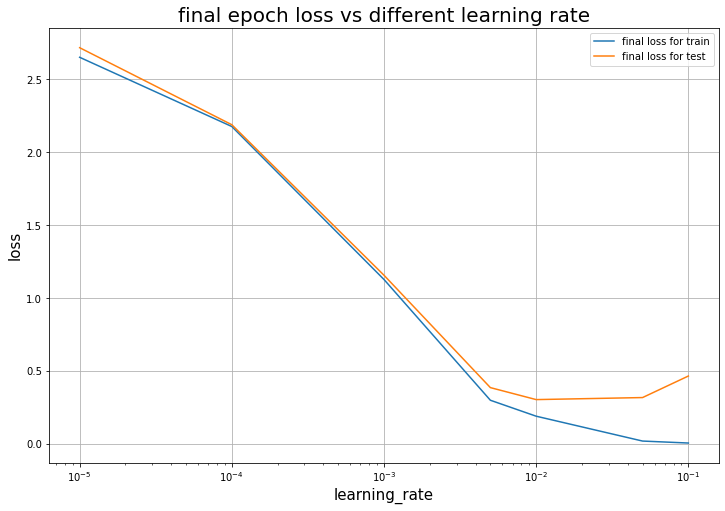

In [12]:
plt.figure(figsize=(12, 8))
plt.semilogx(learning_rates, loss_train_final, label = 'final loss for train')
plt.semilogx(learning_rates, loss_test_final, label = 'final loss for test')
plt.title('final epoch loss vs different learning rate', size=20)
plt.xlabel('learning_rate', size=15)
plt.ylabel('loss', size=15)
plt.legend()
plt.grid()

print(learning_rates[np.argmin(loss_train_final)])
print(learning_rates[np.argmin(loss_test_final)])

We can see from the picture, when learning rate is very small, loss is larger, this is because we only have 40 epoches, low learning rate causes slow convergence and then causes larger loss. When learning rate = 0.1, the learning rate is a bit large, the weight updates are too large and can result in overshooting the optimal weights and not converging to the minimum of the loss function. This can result in poor performance of the model and unstable training.

From the plot and losses, we can choose learning rate = 0.01 as the optimal value.

1.1.2

In [13]:
weight, b , loss_train_list, loss_test_list, acc_train, acc_test, activation1= train_model_SGD(X_train_std, y_train_categorical, X_test_std, y_test_categorical, learning_rate = 0.01, batch_size=128, epochs=40, width = 200)

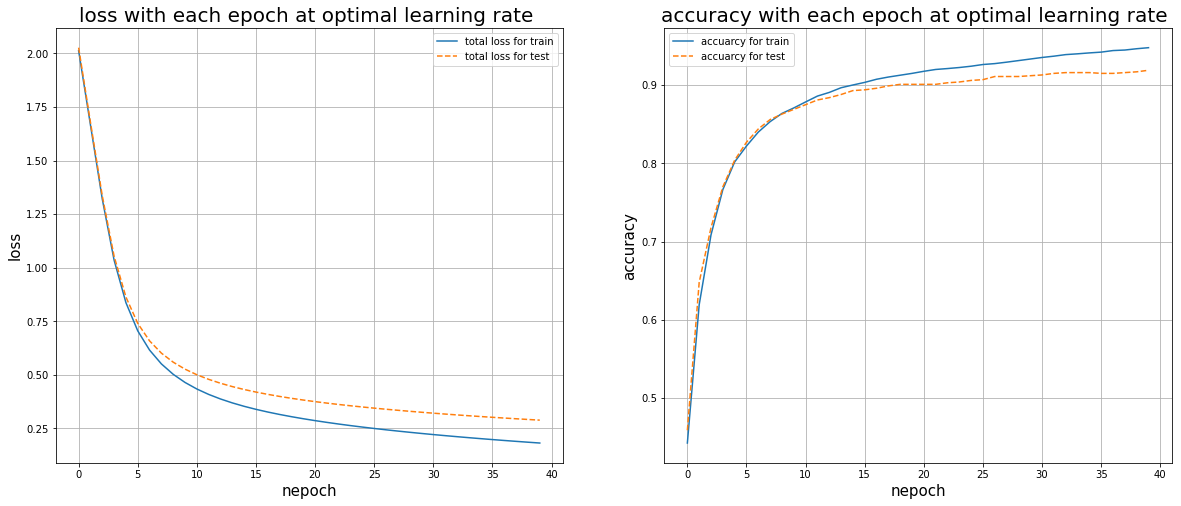

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].plot(range(len(loss_train_list)), loss_train_list,label = 'total loss for train')
axs[0].plot(range(len(loss_test_list)), loss_test_list, '--', label = 'total loss for test')
axs[0].set_title('loss with each epoch at optimal learning rate ', size=20)
axs[0].set_xlabel('nepoch', size =15)
axs[0].set_ylabel('loss', size =15)
axs[0].legend()
axs[0].grid()

axs[1].plot(range(len(acc_train)), acc_train, label = 'accuarcy for train')
axs[1].plot(range(len(acc_test)), acc_test, '--', label = 'accuarcy for test')
axs[1].set_title('accuracy with each epoch at optimal learning rate ', size=20)
axs[1].set_xlabel('nepoch', size =15)
axs[1].set_ylabel('accuracy', size =15)
axs[1].legend()
axs[1].grid()

plt.show()


Since we calculate the total loss, test data have less data, so it have less loss. 

I find as the number of training epochs increases, it is a decrease in the loss and an increase in the accuracy for both datasets. This is because my model learns to fit the training data better over time, leading to better predictions.

Accuracy for test data is a little bit lower and test loss is a little higher than those for training data, since the model is trained using the training data, it is expected that the accuracy for the training dataset will be higher than that of the test dataset. 

These two plots show when the optimal learning rate of 0.01 is chosen, the model performs well without overfitting.

In summary, we need to choose an appropriate learning rate to ensure that the model converges to a good solution and does not overfit. A too-small learning rate might cause slow convergence, whereas a too-large learning rate might cause instability in the training process. By selecting a learning rate of 0.01, the training process is stable, and the model achieves good performance on both training and test datasets.

1.1.3

In [15]:
weight_50, b_50, loss_train_list_50, loss_test_list_50, acc_train_50, acc_test_50, activation1_50 = train_model_SGD(X_train_std, y_train_categorical, X_test_std, y_test_categorical, learning_rate = 0.01, batch_size=128, epochs=40, width = 50)
weight_200, b_200, loss_train_list_200, loss_test_list_200, acc_train_200, acc_test_200, activation1_200= train_model_SGD(X_train_std, y_train_categorical, X_test_std, y_test_categorical, learning_rate = 0.01, batch_size=128, epochs=40,  width = 200)

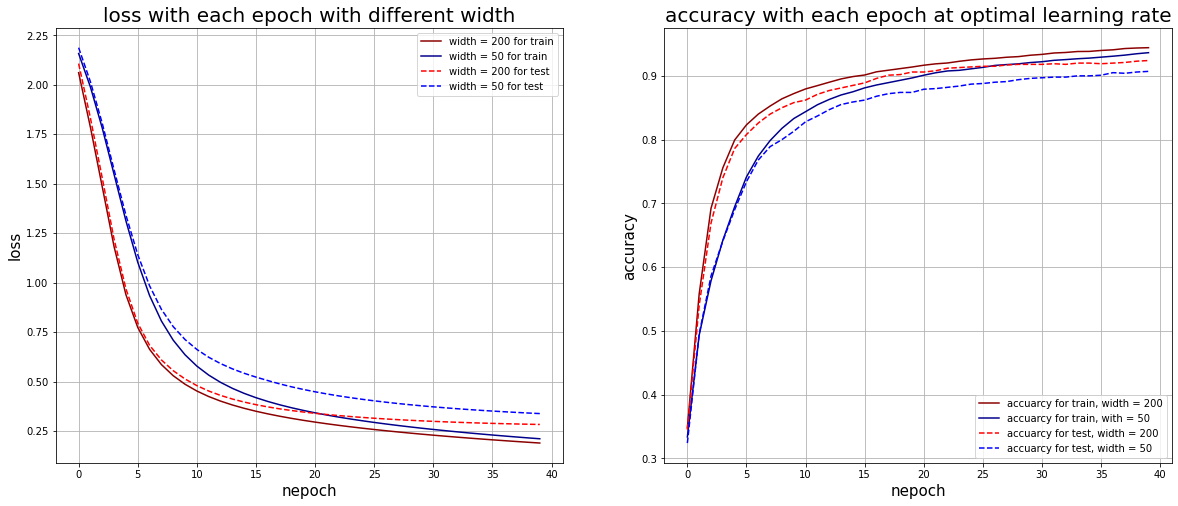

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

axes[0].plot(range(len(loss_train_list_200)), loss_train_list_200,color='darkred', label='width = 200 for train')
axes[0].plot(range(len(loss_train_list_50)), loss_train_list_50, color='darkblue', label='width = 50 for train')
axes[0].plot(range(len(loss_test_list_200)), loss_test_list_200,  '--', color='red', label='width = 200 for test')
axes[0].plot(range(len(loss_test_list_50)), loss_test_list_50, '--', color='blue', label='width = 50 for test')
axes[0].set_title('loss with each epoch with different width', size=20)
axes[0].set_xlabel('nepoch', size=15)
axes[0].set_ylabel('loss', size=15)
axes[0].legend()
axes[0].grid()

axes[1].plot(range(len(acc_train_200)), acc_train_200, color='darkred', label='accuarcy for train, width = 200')
axes[1].plot(range(len(acc_train_50)), acc_train_50, color='darkblue', label='accuarcy for train, with = 50')
axes[1].plot(range(len(acc_test_200)), acc_test_200, '--', color='red', label='accuarcy for test, width = 200')
axes[1].plot(range(len(acc_test_50)), acc_test_50, '--', color='blue', label='accuarcy for test, width = 50')
axes[1].set_title('accuracy with each epoch at optimal learning rate', size=20)
axes[1].set_xlabel('nepoch', size=15)
axes[1].set_ylabel('accuracy', size=15)
axes[1].legend()
axes[1].grid()

plt.show()


Here, I compare the model with different width, 50 neurons and 200 neurons.

By comparing the plots above for the different models, I find 50 neurons model has a little worse performance, which means larger loss and smaller accuracy for train and test data.

This observation suggests that increasing the width of the hidden layers from 50 to 200 neurons leads to a better-performing model, possibly due to the increased capacity of the neural network to learn more complex representations from the input data. 

1.1.4

In [17]:
def dropout(h, dropout_rate):
    """
    Implements dropout with a given dropout rate.
    
    Arguments:
    x -- input numpy array
    dropout_rate -- probability of dropping out a unit
    
    Returns:
    mask -- dropout mask used during training
    """
    
    # Generate a dropout mask for the layer
    mask = np.random.binomial(1, 1-dropout_rate, size=h.shape) / (1-dropout_rate)
    
    return mask

def mlp_drop(X, W,b):
    
    # define the forward function mlp including dropout to get pre-activations and post-activations 
    # X: K x 784 array of inputs
    # w: h_in x h_out array for kernel matrix parameters
    # b: Length h_out 1-D array for bias parameters
    # returns: pre-activations and post-activations and the dropout masks used during training
     
    h0 = X
    a1 = dense(h0, W[0], b[0])
    h1 = softplus(a1,1)
    mask1 = dropout(h1, 0.2)
    h1 = h1 * mask1
    a2 = dense(h1, W[1], b[1])
    h2 = softplus(a2,1)
    mask2 = dropout(h2, 0.2)
    h2 = h2 * mask2
    a3 = dense(h2, W[2], b[2])
    h3 = softplus(a3,1)
    mask3 = dropout(h3, 0.2)
    h3 = h3 * mask3
    a4 = dense(h3, W[3], b[3])
    y = softmax(a4)
    
    return a1, a2, a3, a4, h0, h1, h2, h3, y, mask1, mask2, mask3

def train_model_SGD_drop(X, y, X_test, y_test, learning_rate, batch_size=128, epochs=40):
      
     # Create the parameters for initialization
    dim = 28 * 28
    width = 200
    nclass = 10
    var0 = 2. / (dim + width)
    W0 = np.random.randn(dim, width) * np.sqrt(var0)
    b0 = np.zeros(width)

    var1 = 2. / (width + width)
    W1 = np.random.randn(width, width) * np.sqrt(var1)
    b1 = np.zeros(width)
    var2 = 2. / (width + width)
    W2 = np.random.randn(width, width) * np.sqrt(var2)
    b2 = np.zeros(width)

    var3 = 2. / (width + nclass)
    W3 = np.random.randn(width, nclass) * np.sqrt(var3)
    b3 = np.zeros(nclass)

    W_l = [W0, W1, W2, W3]
    b_l = [b0, b1, b2, b3]  
    W = []
    b = []
    loss_train_list = []
    acc_train = []
    loss_test_list = []
    acc_test = []
    activation1 = []

    for n in range(epochs):
        batch_gen = batch_generator(X, y, batch_size)

        for X_batch, y_batch in batch_gen:
            
            N = len(X_batch)

            a1, a2, a3, a4, h0, h1, h2, h3, y_pred, mask1, mask2, mask3 = mlp_drop(X_batch, W_l, b_l)

            # backward propagation step
            delta4 = output_error(y_batch, a4)
            delta3 = backpropagate(delta4, W3, a3)*mask3
            delta2 = backpropagate(delta3, W2, a2)*mask2
            delta1 = backpropagate(delta2, W1, a1)*mask1
            grad_W0, grad_W1, grad_W2, grad_W3, grad_b0, grad_b1, grad_b2, grad_b3 = grads(delta1, delta2, delta3, delta4, h0, h1, h2, h3, N)
            
            W0 = W0 - learning_rate * grad_W0
            W1 = W1 - learning_rate * grad_W1
            W2 = W2 - learning_rate * grad_W2
            W3 = W3 - learning_rate * grad_W3
            b0 = b0 - learning_rate * grad_b0
            b1 = b1 - learning_rate * grad_b1
            b2 = b2 - learning_rate * grad_b2
            b3 = b3 - learning_rate * grad_b3
            W_l = [W0, W1, W2, W3] 
            b_l = [b0, b1, b2, b3] 
   
        W_l = [W0, W1, W2, W3] 
        b_l = [b0, b1, b2, b3]  
        # Compute predictions for the training and testing data
        y_pred= mlp_drop(X, W_l, b_l)[-4]
        y_pred_test = mlp_drop(X_test, W_l, b_l)[-4]
        activations = mlp_drop(X_test[:batch_size], W_l, b_l)[-7]
        activation1.append(activations)
        
        W.append(W_l)
        b.append(b_l)
        # Calculate the loss and accuracy for the training and testing data
        loss_train_list.append(kl_divergence(y, y_pred)/6000)
        acc_train.append(accuracy(y, y_pred))
        loss_test_list.append(kl_divergence(y_test, y_pred_test)/1000)
        acc_test.append(accuracy(y_test, y_pred_test))  
    
    # Plot histogram of activations for the first hidden layer on the first batch of the test data
    plt.figure()
    plt.hist(activations.flatten(), bins=200,  label="Activations")
    plt.xlabel("Activation value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Epoch {epochs}, Batch {1}, Activation for 0.2 dropout")
    plt.show()
        
    return W, b, loss_train_list, loss_test_list, acc_train, acc_test, activation1

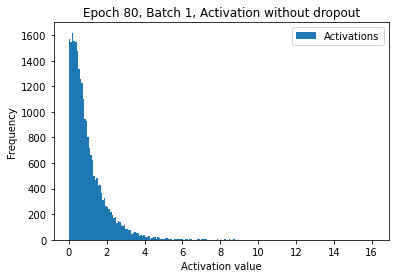

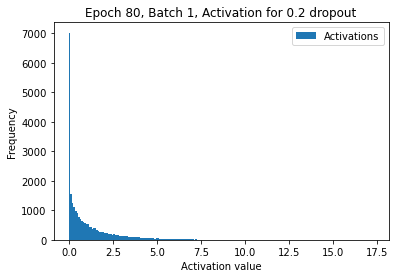

In [18]:
weight_no_drop, b_no_drop, loss_train_list_no_drop, loss_test_list_no_drop, acc_train_no_drop, acc_test_no_drop, activation1 = train_model_SGD(X_train_std, y_train_categorical, X_test_std, y_test_categorical, learning_rate = 0.1, batch_size=128, epochs=80,plot=True)
weight_drop, b_drop, loss_train_list_drop, loss_test_list_drop, acc_train_drop, acc_test_drop, activation1_drop= train_model_SGD_drop(X_train_std, y_train_categorical, X_test_std, y_test_categorical, learning_rate = 0.1, batch_size=128, epochs=80)

From the histograms above, we can see the effect of dropout on sparsity. 

Without dropout: The histogram of activations displays a significant mode far from zero, indicating that a large proportion of the units exhibit high activation values.

With dropout (p = 0.2): The histogram of activations reveals a sharp peak at zero, implying that very few units have high activation values.

We found that while doing dropout, the activations of the hidden units become sparse, even when no sparsity inducing regularizers are present. Thus, dropout automatically leads to sparse representations. 

Higher sparsity typically results in a more robust model, as it reduces the risk of overfitting. This is because sparse representations enforce the model to rely on fewer, more meaningful features rather than memorizing noise or irrelevant patterns in the training data. As a result, dropout not only serves as a regularization technique but also promotes sparsity, further enhancing the model's generalization capabilities.

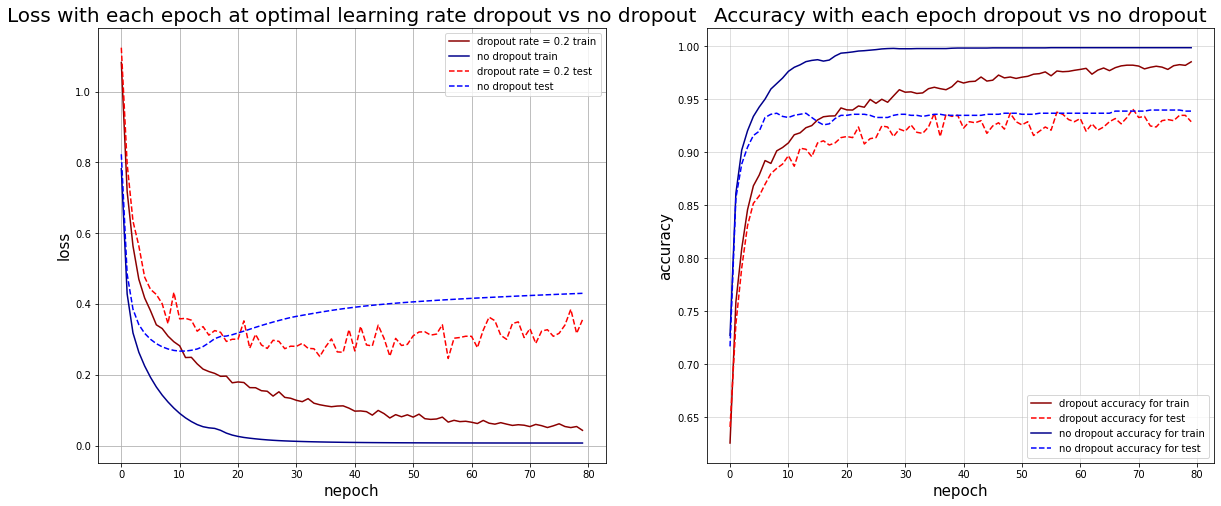

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].plot(range(len(loss_train_list_drop)), loss_train_list_drop, color='darkred', label='dropout rate = 0.2 train')
ax[0].plot(range(len(loss_train_list_no_drop)), loss_train_list_no_drop, color='darkblue', label='no dropout train')
ax[0].plot(range(len(loss_test_list_drop)), loss_test_list_drop, '--', color='red', label='dropout rate = 0.2 test')
ax[0].plot(range(len(loss_test_list_no_drop)), loss_test_list_no_drop, '--', color='blue', label='no dropout test')
ax[0].set_title('Loss with each epoch at optimal learning rate dropout vs no dropout', size=20)
ax[0].set_xlabel('nepoch', size=15)
ax[0].set_ylabel('loss', size=15)
ax[0].legend()
ax[0].grid()

ax[1].plot(range(len(acc_train_drop)), acc_train_drop,color='darkred', label='dropout accuracy for train')
ax[1].plot(range(len(acc_test_drop)), acc_test_drop, '--',color='red', label='dropout accuracy for test')
ax[1].plot(range(len(acc_train_no_drop)), acc_train_no_drop, color='darkblue', label='no dropout accuracy for train')
ax[1].plot(range(len(acc_test_no_drop)), acc_test_no_drop, '--', color='blue',  label='no dropout accuracy for test')
ax[1].set_title('Accuracy with each epoch dropout vs no dropout', size=20)
ax[1].set_xlabel('nepoch', size=15)
ax[1].set_ylabel('accuracy', size=15)
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.show()


From the plots above, we can observe the effectiveness of incorporating a dropout with a 0.2 rate in mitigating overfitting in neural networks. The blue line represents the model without dropout, and the test and train curves clearly exhibit overfitting.

In detail, for model without dropout, the loss for training data is almost 0, the accuracy for the training data is almost 1 after 40 epoches. But the loss for test begins to diverge after 10 epochs, and the accuracy decreases after 20 epoches.

However, for the model with dropout, both the training and test data show convergence in loss and accuracy as the number of epochs increases. This indicates that the model generalizes better to unseen data.

By incorporating dropout and temporarily removing some neurons from the network during training, the co-adaptation of neurons is reduced. This compels the network to learn more robust and meaningful features that generalize better to new data. As a result, the model with dropout demonstrates improved performance and resistance to overfitting.

#### 1.2 Dimensionality reduction (20 marks)

1.2.1

Now we will implement PCA. Before we do that, let's pause for a moment and
think about the steps for performing PCA. Assume that we are performing PCA on
some dataset $\boldsymbol X$ for $k$ principal components. 
We then need to perform the following steps, which we break into parts:

1. Compute the covariance matrix  $\mathbf C = \mathbf X^\top \mathbf X/(n-1)$
1. Find eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$
3.  Sort by the largest eigenvalues and the corresponding eigenvectors.
4.  Compute the projection onto the spaced spanned by the top $n$ eigenvectors.


In [20]:
def standardise(X):
    # X: the input data
    # return: the standardized X
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar, mu, std_filled


def pca_function(X,m):
    
    '''
    Principal component analysis to reduce dimension on in put data
    X: input data, shape (N, p)
    m: principal component numbers
    
    returns: 
    X_pca: data with reduced dimention, shape(N, m)
    eigenvectors: the eigenvectors of C.
    eigenvalues: the eigenvalues of C
    '''

    # create covariance matrix S
    C = 1.0/(len(X)-1) * np.dot(X.T, X)


    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, m, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors) 

    return X_pca, eigenvectors, eigenvalues

The preprocessing steps we will do are:
1. Convert unsigned interger 8 (uint8) encoding of pixels to a floating point number between 0 and 1.
The next two steps of the preprocessing is:

2. Subtract from each image the mean $\boldsymbol \mu$.
3. Scale each dimension of each image by $\frac{1}{\sigma}$ where $\sigma$ is the stardard deviation.
Lets now compute the variance in each principle component. Then print the variance for the first three principle components.

In [21]:
# Load the data
data_train_noisy = np.loadtxt('MNIST_train_noisy.txt')/255

# standardise the data
X, mu, std_filled = standardise(data_train_noisy)

The total variance of the data is V = $\sum_{j=1}^p\lambda_j$, explained variance ratio of each component is $\lambda_j/V$.

In [22]:
# get the explained variance
C = 1.0/(len(X)-1) * np.dot(X.T, X)
all_eigenvalues, _ = np.linalg.eig(C)
total_variance = abs(all_eigenvalues.sum())

m_list = np.arange(10, 500, 5)
ratio = []
for i in m_list:
    X_pca, eigenvectors, eigenvalues = pca_function(X,m=i)
    explained_variances = eigenvalues /  total_variance ## <-- SOLUTION   
    cumulative_variance_ratio = np.cumsum(explained_variances)[-1]
    ratio.append(cumulative_variance_ratio)
    if 0.699<cumulative_variance_ratio<0.705:
        print('70% of variance is explained when m = {}'.format(i))
    if 0.799<cumulative_variance_ratio<0.805:
        print('80% of variance is explained when m = {}'.format(i))
    if 0.899<cumulative_variance_ratio<0.905:
        print('90% of variance is explained when m = {}'.format(i))

70% of variance is explained when m = 215
80% of variance is explained when m = 300
90% of variance is explained when m = 410


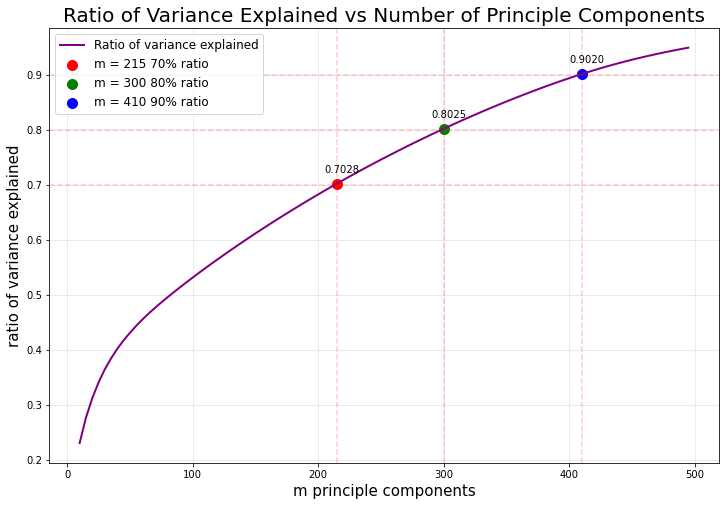

In [23]:
# set figure size and background color
fig = plt.figure(figsize=(12, 8), facecolor='white')

# plot the data with custom line colors and markers
plt.plot(m_list, ratio, color='purple', linewidth=2, label='Ratio of variance explained')

# add vertical lines at specific x values
plt.axvline(215, color='red', linestyle='--', alpha=0.2)
plt.axvline(300, color='red', linestyle='--', alpha=0.2)
plt.axvline(410, color='red', linestyle='--', alpha=0.2)

# add horizontal lines at specific x values
plt.axhline(0.70, color='red', linestyle='--', alpha=0.2)
plt.axhline(0.80, color='red', linestyle='--', alpha=0.2)
plt.axhline(0.90, color='red', linestyle='--', alpha=0.2)

# add scatter plot markers at specific x values
plt.scatter(215, ratio[41], s=100, color='red', label='m = 215 70% ratio')
plt.scatter(300, ratio[58], s=100, color='green', label='m = 300 80% ratio')
plt.scatter(410, ratio[80], s=100, color='blue', label='m = 410 90% ratio')

# add ratio values as text annotations
plt.text(215-10, ratio[41]+0.02, f'{ratio[41]:.4f}')
plt.text(300-10, ratio[58]+0.02, f'{ratio[58]:.4f}')
plt.text(410-10, ratio[80]+0.02, f'{ratio[80]:.4f}')

# add axis labels and title with custom font sizes
plt.xlabel('m principle components', fontsize=15)
plt.ylabel('ratio of variance explained', fontsize=15)
plt.title('Ratio of Variance Explained vs Number of Principle Components', fontsize=20)

# add legend with custom font size
plt.legend(fontsize=12)

# customize grid lines
plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

# show the plot
plt.show()


From the above picture, we can clearly see, to explain 70%, 80%, 90% of the variance, m should be 215, 300, 410 separately.

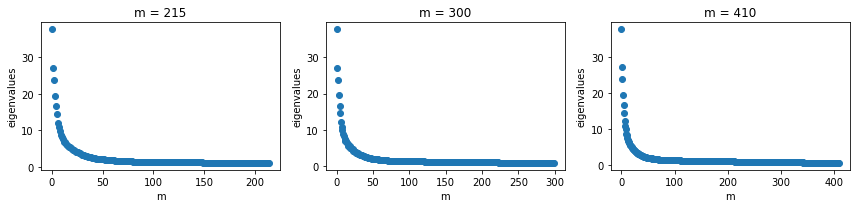

In [24]:
# Calculate PCA for different values of m
X_pca1, eigenvectors1, eigenvalues1 = pca_function(X, m=215)
X_pca2, eigenvectors2, eigenvalues2 = pca_function(X, m=300)
X_pca3, eigenvectors3, eigenvalues3 = pca_function(X, m=410)

# Create a 1x3 grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

# Plot the first subplot
axs[0].scatter(np.arange(len(eigenvalues1)), eigenvalues1)
axs[0].set_xlabel('m')
axs[0].set_ylabel('eigenvalues')
axs[0].set_title('m = 215')

# Plot the second subplot
axs[1].scatter(np.arange(len(eigenvalues2)), eigenvalues2)
axs[1].set_xlabel('m')
axs[1].set_ylabel('eigenvalues')
axs[1].set_title('m = 300')

# Plot the third subplot
axs[2].scatter(np.arange(len(eigenvalues3)), eigenvalues3)
axs[2].set_xlabel('m')
axs[2].set_ylabel('eigenvalues')
axs[2].set_title('m = 410')

# Adjust the spacing between subplots and show the figure
fig.tight_layout()
plt.show()


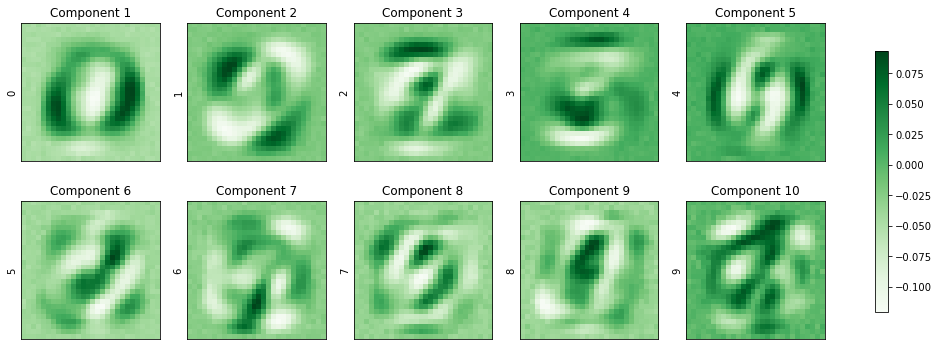

In [25]:
# visualise the first m=10 principal components from PCA
m = 10
X_pca, eigenvectors, eigenvalues = pca_function(X, m) 
nrow = 2
ncol = 5

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(18, 6))

for i, ax in enumerate(axs.reshape(-1)): 
    b = ax.imshow(eigenvectors[:, i].reshape([28, 28]), cmap='Greens')
    ax.set_ylabel(str(i))
    ax.set_title(f"Component {i+1}")
    ax.set_xticks([])
    ax.set_yticks([])

fig.colorbar(b, ax=axs, location='right', shrink=0.8)

plt.show()

The above is the visulization for the first m = 10 principal components from PCA.

1.2.2

In [26]:
# normalise min max to 0-1
def normalize_nmf(X):
    '''
    X: the input data, shape (N, 784)
    '''
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X)) 
    return X_norm

# lets define a cost matrix to compare the difference
def cost(X,W,H):
    
    '''
    a cost matrix to compare the difference
    X; data, shape (N, 784)
    W: shape (N, m)
    H: shape (m, 784)
    '''
    
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H) ## <-- SOLUTION
    
    # Compute the Euclidean distance-based objective function
    cost_value = (diff * diff).sum() / (X.shape[0]*X.shape[1]) ## <-- SOLUTION
    
    # Here we have also normalized the sum by the nummber of terms in the sum (but it's not necessary).
    
    return cost_value

def nmf(X, m, n_iters, error=1e-5):
    
    '''
    Non-negative matrix factorisation (NMF)
    X; data, shape (N, 784)
    m: the number of dimensions on which to project
    n_iters: maximum iteration numbers
    '''

    # setting the random seed (just so everyone gets the same results...)
    np.random.seed(0)

    # m x k components matrix, usually interpreted as the coefficients, where m is the number of data
    W = np.random.rand(X.shape[0], m)

    # k x n matrix interpreted as the basis set, where n is the number of features (e.g. pixels)
    H = np.random.rand(m, X.shape[1])
    # empty list 
    cost_values = []
    pseudo_count = 0.001 ## this is just a small value that we place at the denominator to avoid division by zero
    # loop over the n iterations
    for i in range(n_iters):

        # compute the update on H
        H = H * ((W.T.dot(X)) / (W.T.dot(W.dot(H))+pseudo_count)) 

        # compute the update on W
        W = W * ((X.dot(H.T)) / ((W.dot(H.dot(H.T)))++pseudo_count)) 

        # compute the chi2 and append to list
        cost_values.append(cost(X,W,H))
        
        if i >= 1 and np.linalg.norm(cost_values[-1]-cost_values[-2])/np.linalg.norm(cost_values[-2]) <= error:
            print(f"Model converges at the {i+1}th iteration")
            break
        
    return cost_values, W, H

In [27]:
# Load the data
data_train_noisy = np.loadtxt('MNIST_train_noisy.txt')/255
# normalize X
X_norm = normalize_nmf(data_train_noisy)
# choose the number of dimensions on which to project

m=10
loss_list, W, H = nmf(X_norm, m, n_iters=1000)

Model converges at the 640th iteration


The following plot shows convergence to torlerance 1e-5 after 640 iterations.

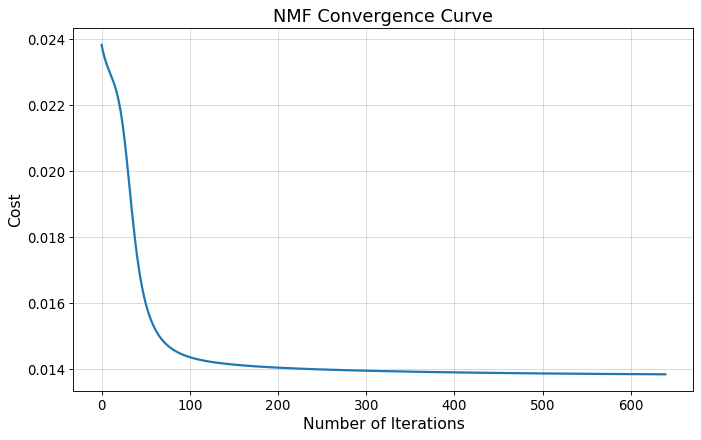

In [28]:
# plotting the cost
plt.figure(figsize=(10,6), dpi = 80)
plt.plot(loss_list, linewidth=2)
plt.xlabel('Number of Iterations', fontsize=14)
plt.ylabel('Cost', fontsize=14)
plt.title('NMF Convergence Curve', fontsize=16)
plt.grid(alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=10)
plt.show()


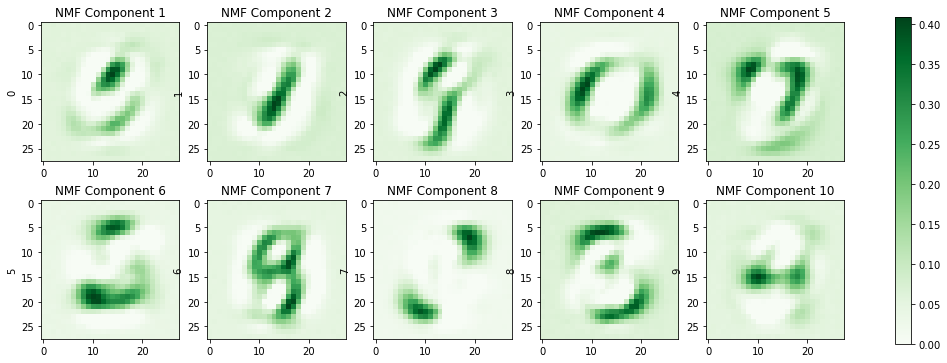

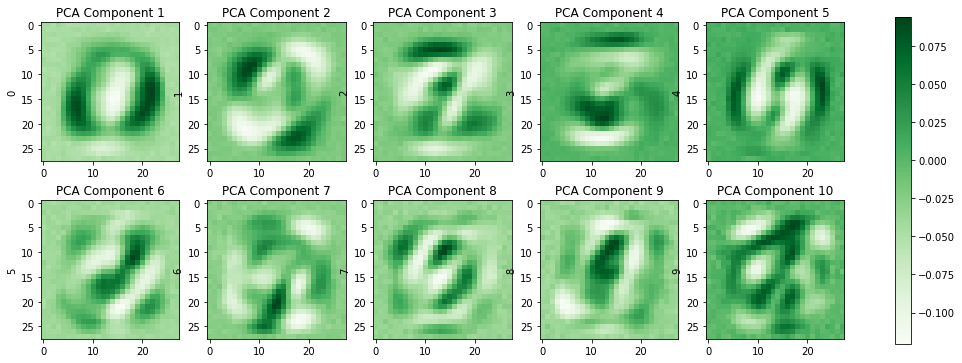

In [29]:
nrow = 2; ncol = 5;

# loop through the components and display them using imshow
fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(18,6))

for i,ax in enumerate(axs.reshape(-1)): 
    b = ax.imshow((H.T)[:,i].reshape([28,28]), cmap='Greens')
    ax.set_ylabel(str(i))
    ax.set_title(f"NMF Component {i+1}")
    
fig.colorbar(b, ax=axs[:2, :], location='right');

# PCA
fig, axs = plt.subplots(nrows=2, ncols=5,figsize=(18,6))
for i,ax in enumerate(axs.reshape(-1)): 
    b = ax.imshow(eigenvectors[:,i].reshape([28,28]), cmap='Greens')
    ax.set_ylabel(str(i))
    ax.set_title(f"PCA Component {i+1}")
        
fig.colorbar(b, ax=axs[:2, :], location='right');


##### Discuss the comparison between NMF and PCA components, explaining why they differ:
PCA and NMF are both dimensionality reduction techniques.

For PCA components, imshow can show the variation of the component values across the rows and columns of the data matrix. While for NMF components, imshow can show the structure of the basis vectors and the coefficients. 

Plots for NMF components appear more bright than those for PCA components because NMF requires that both the basis vectors and coefficients are non-negative. This means that the values of the basis vectors and coefficients will always be non-negative, and therefore the resulting images will also be non-negative. PCA does not impose any constraints on the signs of the components, so principal components computed by PCA may contain both positive and negative values, which can cancel each other out and causes sparsity when visualized using imshow, so plots for PCA components may appear less bright.

NMF components are not as clear as PCA components, because NMF is a non-convex optimization problem, which means that the algorithm may converge to a local minimum rather than the global minimum. This can result in NMF components that are more difficult to interpret and may contain noise or artifacts. NMF enforces non-negativity constraints on the basis vectors and coefficients, the resulting components may be less sparse than those obtained using PCA, which can make it more difficult to identify the specific patterns and structures captured by each component.

PCA is a convex optimization problem, which means that the algorithm is guaranteed to converge to the global minimum. Additionally, PCA does not impose any constraints on the signs of the components, which can make it easier to identify the specific patterns and structures captured by each component.


1.2.3  Image denoising:

In [30]:
# deal with the data without noise
original_data = pd.read_csv('MNIST_train.csv')
data_train = original_data.to_numpy()[:,1:]/255
original_data_test = pd.read_csv('MNIST_test.csv')
data_test = original_data_test.to_numpy()[:,1:]/255
# standardize for pca and normalise for nmf
X_no_noisy, mu_no_noisy, std_filled_no_noisy = standardise(data_train)
X_norm_no_noisy = normalize_nmf(data_train)
X_test_no_noisy = (data_test-mu_no_noisy)/std_filled_no_noisy
X_norm_test_no_noisy = normalize_nmf(data_test)
# Load the data with noise
data_train_noisy = np.loadtxt('MNIST_train_noisy.txt')/255
data_test_noisy = np.loadtxt('MNIST_test_noisy.txt')/255

X_noise, mu, std_filled = standardise(data_train_noisy)
X_noisy_test = (data_test_noisy-mu)/std_filled

# nmf normalization
X_norm = normalize_nmf(data_train_noisy)
X_norm_test = normalize_nmf(data_test_noisy)

In [31]:
# pca
m = 100
X_pca, eigenvectors, eigenvalues = pca_function(X_noise,m)

In [32]:
# nmf
m = 100
# predict w and h from train data
loss_list, W, H = nmf(X_norm, m, n_iters=2000, error=0.00005)

Model converges at the 1200th iteration


The below plot shows the model converge at the 1200th iteration.

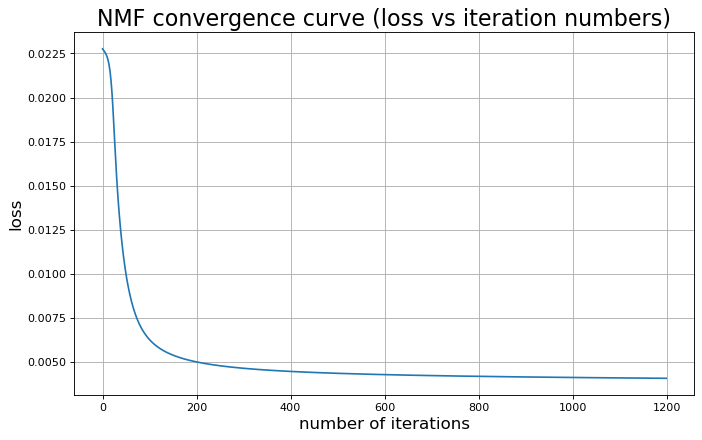

In [33]:
# plotting the cost
plt.figure(figsize=(10,6), dpi = 80)
plt.plot(loss_list)
plt.xlabel('number of iterations', size = 15)
plt.ylabel('loss', size = 15)
plt.title('NMF convergence curve (loss vs iteration numbers)', size = 20)
plt.grid(True)
plt.show()

 For PCA, linear combination can be done by computing the dot product between the test data and the matrix of eigenvectors obtaining from the training data, the formula is:
 $$PCA components = X_{test} @ eigenvectors$$

 For NMF, this can be done by computing the dot product between the test data and the matrix of non-negative coefficients obtained from the training data, the formula is:
 $$NMF components = X_{test} @ H^T$$

 To obtain the reconstructed images, we can apply the PCA and NMF components by computing the dot product between the components and the matrix of eigenvectors(PCA) or non-negative coefficients(NMF):

$$PCA (reconstructed) images = PCA components @ eigenvectors^T$$
$$NMF (reconstructed) images = NMF components @ H$$

In [34]:
H_T = H.T
# linear combination for noisy image
pca = X_noisy_test @ eigenvectors
nmf = X_norm_test @ H_T

# reconstruct the image by pca components
im_pca = pca @ eigenvectors.T
# reconstruct the image by nmf components
im_nmf = nmf @ H
#rescale the image
X_pca_image_rescale = (im_pca * std_filled + mu)*255
X_nmf_image_rescale = (im_nmf * (np.max(data_train_noisy)-np.min(data_train_noisy)) + np.min(data_train_noisy))*255

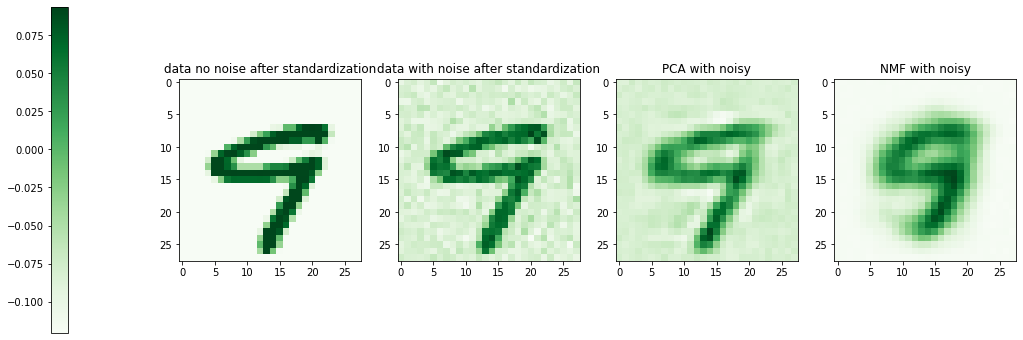

In [35]:
# deal with the first index image
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 6))
id = 15
# plot the test image without noise for pca
axs[0].imshow(255*data_test[id].reshape(28,28), cmap='Greens')
axs[0].set_title('data no noise after standardization')

# plot the test image with noise for pca
axs[1].imshow(255*data_test_noisy[id].reshape(28,28), cmap='Greens')
axs[1].set_title('data with noise after standardization')

# plot the first image
axs[2].imshow(X_pca_image_rescale[id].reshape(28,28), cmap='Greens')
axs[2].set_title('PCA with noisy')


# plot the first image
axs[3].imshow(X_nmf_image_rescale[id].reshape(28,28), cmap='Greens')
axs[3].set_title('NMF with noisy')
# add a colorbar
fig.colorbar(b, ax=axs, location='left');

PCA and NMF can be used for denoising data by projecting the noisy data onto a lower-dimensional subspace and reconstructing the denoised data from the basis vectors or principal components of the subspace. 

We can see PCA and NMF perform differently in terms of identifying the most important gloabal feature of the digit and removing the background noise.

The denoising image by PCA is more effective in preserving the overall structure and large-scale features of the data, while NMF is more effective in preserving the local structure and fine-scale features of the data. This is because PCA tends to capture global variance patterns in the data, while NMF tends to capture localized and non-negative patterns in the data.

NMF is more effective in removing the background noise because NMF captures localized and non-negative patterns in the data and can effectively separate the signal from the noise at a fine scale.

In another way, PCA can work well for Gaussian and additive noise, NMF is a good choice for denoising data that has non-Gaussian and non-additive noise, and where the signal and noise are not clearly separated. Because NMF is based on a non-negative factorization of the data, which assumes that the data is non-negative and has additive noise that is also non-negative. Gaussian noise, however, is not necessarily non-negative, and its distribution may not be well-suited for NMF. NMF enforces non-negativity in the decomposition, it may not be able to capture negative components or features in the data, which may result in a loss of information or distortion in the denoising process.

 PCA is based on the covariance matrix of the data, which assumes that the data is normally distributed. In the case of Gaussian noise, the covariance matrix of the noisy data can be estimated accurately, and the principal components obtained from the decomposition can effectively capture the signal in the data. Moreover, when the noise is Gaussian and additive, it can be modeled as a random variable with a zero mean and a constant variance, which can be subtracted from the noisy data to obtain the clean signal. This is equivalent to centering the data around the origin, which is one of the assumptions of PCA.

1.2.4

In [36]:
def MSE(image, image_predict):
    # want to calculate MSE between the reconstructed and test image with no noise
    # image: original test image with no noise
    # image_predict: reconstructed for test with noise
    # return: MSE
    mse = np.mean((image - image_predict)**2)

    return mse

In [37]:

# get the two MSE lists
m = np.arange(5, 401, 5)
mse_im_no_noise = []
mse_im_noise = []
for i in m:
    _, evectors, _ = pca_function(X_noise,i)
    # linear combination for noisy image for pca
    pca = X_noisy_test @ evectors
    # reconstruct the image by pca compoents
    im_pca = pca @ evectors.T
    # rescale PCA image
    im_pca_original = im_pca * std_filled + mu
    # mse with the test set of no noise images
    mse_no_noise = MSE(data_test*255, im_pca_original*255)
    # mse with the test set of noisy images
    mse_noise = MSE(data_test_noisy*255, im_pca_original*255)
    mse_im_no_noise.append(mse_no_noise)
    mse_im_noise.append(mse_noise)

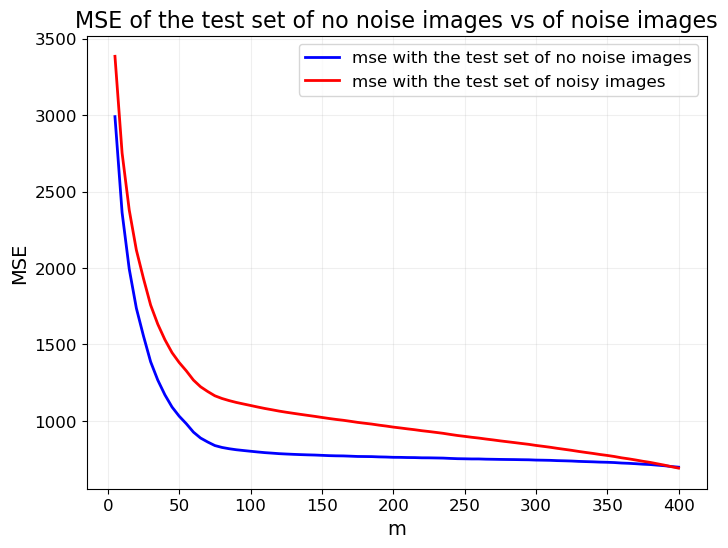

In [38]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
ax.plot(m, mse_im_no_noise, linewidth=2, color='blue', label= 'mse with the test set of no noise images')
ax.plot(m, mse_im_noise, linewidth=2, color='red', label = 'mse with the test set of noisy images')

# Add axis labels and a title
ax.set_xlabel('m', fontsize=14)
ax.set_ylabel('MSE', fontsize=14)
ax.set_title('MSE of the test set of no noise images vs of noise images', fontsize=16)
# Add a legend
ax.legend(fontsize=12)
# Customize the plot
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.tick_params(axis='both', which='both', labelsize=12)
ax.grid(alpha=0.2)
# Show the plot
plt.show()

After rescaling, we can see MSE between the reconstructed image and noisy images data is higher than MSE between the reconstructed image and no noise images data. This is because PCA is a denoising method that attempts to separate the signal from the noise. During the PCA denoising process, the principal components capturing the signal are retained, while the components that capture the noise are discarded. Therefore, when the reconstructed image is compared to the noise-free image, the signal has been better preserved, resulting in a lower MSE. On the other hand, when the reconstructed image is compared to the noisy image, there may still be some residual noise in the reconstructed image, resulting in a higher MSE.

The MSE decreases with an increasing number of principal components used in PCA, because PCA can be used to filter out the noise in the data by representing the noisy data as a linear combination of a small number of dominant principal components. As we increase the number of principal components used in the reconstruction, we are able to capture more of the signal in the data, which leads to a better approximation of the image and a lower MSE.

However, it's important to note that increasing the number of retained principal components also increases the complexity of the model and may lead to overfitting. So a good m can be obtained at the elbow point about at m = 80.

In [39]:
m_list = [10, 40, 100, 200]
im_pca_list = []
for m in m_list:
    X_pca, evectors, evalues = pca_function(X_noise,m)
    # linear combination for noisy image for pca
    pca = X_noisy_test @ evectors
    im_pca = pca @ evectors.T
    im_pca_original = im_pca * std_filled + mu
    im_pca_list.append(im_pca_original)

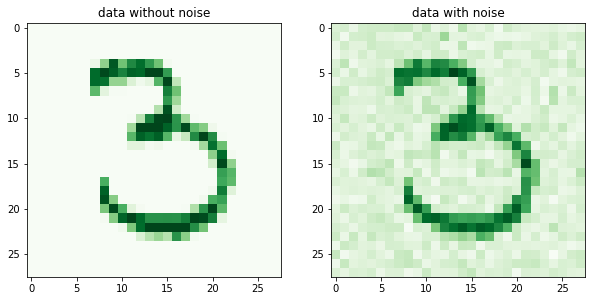

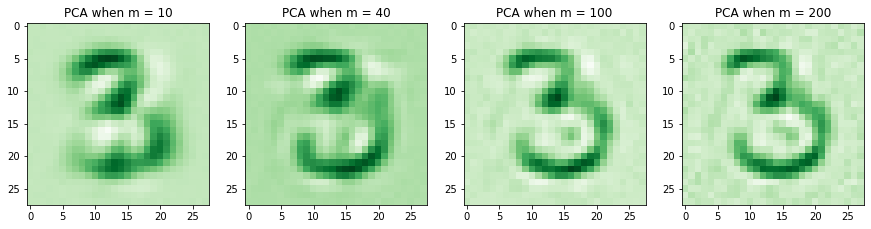

In [40]:
# deal with the first index image
id = 66
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axs[0].imshow(data_test[id].reshape(28,28), cmap='Greens')
axs[0].set_title('data without noise')
axs[1].imshow(data_test_noisy[id].reshape(28,28), cmap='Greens')
axs[1].set_title('data with noise')
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
for i in range(len(im_pca_list)):
    axs[i].imshow(im_pca_list[i][id].reshape(28,28), cmap='Greens')
    axs[i].set_title('PCA when m = {}'.format(m_list[i]))

We can find when m = 10, it is the most not clear, m =40 not clear as well. And m =100 or 200, the image is better.

So if we use only 10 or 40 principal components to represent the original image, we capture only a small fraction of the original image's variance.  This can lead to a loss of important information, resulting in a poorly reconstructed image. Using too few principal components in PCA can result in a bad image reconstruction. When we use a small number of principal components to represent the original image, we capture only a small fraction of the original image's variance. This can lead to a loss of important information, resulting in a poorly reconstructed image. In other words, using too few components can result in underfitting the data. 

And after careful observation, m=100 has better denoising results and it has less noise than m =200, this is because, m=100 is closer to the optimal 'elbow point' as we discussed before, and adding too many principal components may capture more noise or artifacts present in the data and leads to overfitting.

#### 1.3 Gaussian Mixture Models (20 marks)
1.3.1

In [41]:
from scipy.stats import multivariate_normal 
from matplotlib.patches import Ellipse

class GMModel:
    """Struct to define Gaussian Mixture Model"""
    """:param dim: number of mixture components"""
    """:param weights: mixture weights"""
    """:param mu: mixture component means for each cluster"""
    """:param sigma: mixture component covariance matrix for each cluster"""
    
    def __init__(self, X, dim):
        """Initialises parameters through random split of the data"""
        
        self.dim = dim

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        n,m = X.shape 
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.dim)

        # initial value of mean of k Gaussians
        self.mu = [  X[row_index,:] for row_index in random_row ]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [ np.cov(X.T) for _ in range(self.dim) ] 


def cluster_probabilities(gmm, X):
    """
    Predicts probability of each data point with respect to each cluster
    X: input data shape(N, 784)
    gmm: GMModel
    returns:
    weights: probability to be some cluster
    """
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) 
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        
    return weights

def predict(gmm, X):
    """Performs hard clustering"""
    '''
    gmm: GMModel
    X: input data shape(N, 784)
    returns: the predicted clusters
    '''
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1) # MAP estimate

        
def fitStep(gmm,X, max_iter=2000, error=1e-6):
    """Performs an EM step by updating all parameters"""
    # gmm: the model
    # X: the input
    # max_iter: the maximum iteration numbers
    # error: the torlerance
    mu_list = []
    sigma_list = []
    for m in range(max_iter):
        # E-Step: update weights and phi holding mu and sigma constant
        weights = cluster_probabilities(gmm,X) 
        gmm.phi = weights.mean(axis=0)

        # M-Step: update mu and sigma holding pi and weights constant
        for i in range(gmm.dim):
            weight = weights[:, [i]]
            total_weight = weight.sum()
            gmm.mu[i] = (X * weight).sum(axis=0) / total_weight 
            gmm.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)
        mu_list.append(1*gmm.mu)
        sigma_list.append(1*gmm.sigma)
     
        if m > 2:
            mu_norm = np.linalg.norm(np.array(mu_list[-1]) - np.array(mu_list[-2])) / np.linalg.norm(np.array(mu_list[-2]))
            sigma_norm = np.linalg.norm(np.array(sigma_list[-1]) - np.array(sigma_list[-2])) / np.linalg.norm(np.array(sigma_list[-2]))
            if mu_norm < error and sigma_norm < error:
                print(f'Converged at {m}th iteration')
                break
   

In [42]:
original_data = pd.read_csv('MNIST_train.csv')
# PCA on the first N = 1000 images
data_train_1000 = original_data.to_numpy()[:1000,1:]/255
# get the labels
y_train = original_data.to_numpy()[:1000,0]
# standardize the data
X_std, mu_no_noisy, std_filled_no_noisy = standardise(data_train_1000)
# use the first 5 principal components
X_pca_1000, evectors_1000, _ = pca_function(X_std, m = 5)

In [43]:
np.random.seed(12345)
gmm = GMModel(X_pca_1000,10)
fitStep(gmm,X_pca_1000, max_iter=2000, error=1e-5)

Converged at 420th iteration


We can see the GMM model converges at 449th iteration.

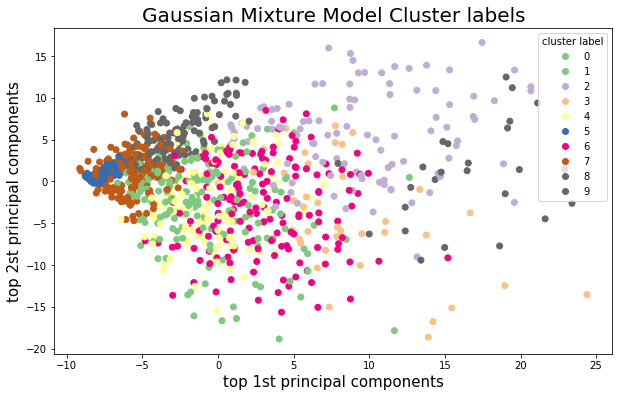

In [44]:
# predict the lables
y_pred = predict(gmm, X_pca_1000)

n_clu = np.unique(y_pred)

# Visualise the space spanned by the top two principal components
plt.figure(figsize=(10, 6))
# colouring each point according to their cluster
s = plt.scatter(X_pca_1000[:, 0], X_pca_1000[:, 1], c=y_pred, cmap='Accent');
plt.legend(handles=s.legend_elements()[0], labels = [str(i) for i in n_clu], title = 'cluster label')
plt.xlabel('top 1st principal components', size=15)
plt.ylabel('top 2st principal components', size=15)
plt.title('Gaussian Mixture Model Cluster labels', size = 20)
plt.show()


1.3.2

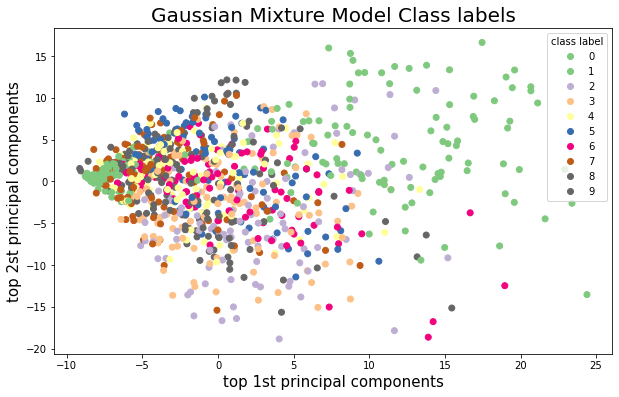

In [45]:
# Visualise the space spanned by the top two principal components
plt.figure(figsize=(10, 6))
# colouring each point according to their class
s2 = plt.scatter(X_pca_1000[:, 0], X_pca_1000[:, 1], c=y_train, cmap='Accent');
plt.legend(handles=s2.legend_elements()[0], labels = [str(i) for i in np.unique(y_train)], title='class label')
plt.xlabel('top 1st principal components', size=15)
plt.ylabel('top 2st principal components', size=15)
plt.title('Gaussian Mixture Model Class labels', size = 20)
plt.show()


In [46]:
def log_like(gmm, X, y):
    """get likelihood of each mixture component"""
    # gmm: model
    # X: dataset
    # y: its labels
    # returns: a matrix mean_log_like with the mean log-likelihoods for each class and each mixture component.
    N = gmm.dim
    cla = np.unique(y)
    mean_log_like = np.zeros((len(cla), N))
    
    for j in cla:
        X_each = np.take(X, np.where(y==j)[0], axis=0)
        for i in range(N):
            # likelihood of data belonging to i-th cluster 
            distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i]) 
            log_l = np.log(distribution.pdf(X_each)+1e-25)
            mean_log_like[j, i] = log_l.mean()
            
    return mean_log_like

The next map funtion maps the class labels to the best-fitting cluster index.

In [47]:
def map(X, gmm, y_train):
    # finds the indices of the data points with the current class label, creates a mapping from class labels to cluster indices
    # X: data set
    # y_train: its labels
    # returns: a dictionary and best index
    classes = np.unique(y_train)  
    
    mean_log_like_list = log_like(gmm, X,  y_train)
    # Find the indices of data points with the current class label
    index = np.argmax(mean_log_like_list, axis = 1)
    # Create a mapping from class labels to cluster indices
    class_to_cluster = {}
    for i in classes:
        # Map the class label to the cluster index
        class_to_cluster[i] = index[i]
        print(f'class label {i} best-fitting cluster index is {index[i]}')
    return class_to_cluster, index
 
 
# Print the mapping
class_to_cluster,index = map(X_pca_1000, gmm, y_train)
print(class_to_cluster)


class label 0 best-fitting cluster index is 2
class label 1 best-fitting cluster index is 5
class label 2 best-fitting cluster index is 1
class label 3 best-fitting cluster index is 6
class label 4 best-fitting cluster index is 4
class label 5 best-fitting cluster index is 6
class label 6 best-fitting cluster index is 6
class label 7 best-fitting cluster index is 4
class label 8 best-fitting cluster index is 2
class label 9 best-fitting cluster index is 4
{0: 2, 1: 5, 2: 1, 3: 6, 4: 4, 5: 6, 6: 6, 7: 4, 8: 2, 9: 4}


In [48]:
aic_list =[]
like_list = log_like(gmm, X_pca_1000,  y_train)
l_max = np.argmax(like_list, axis = 1)
AIC = 20 - 2*like_list[l_max]
l_max 

array([2, 5, 1, 6, 4, 6, 6, 4, 2, 4])

The best-fitting cluster index for each class was determined using log-likelihood, which is a measure of how well the mixture model fits the data. The best-fitting cluster index for each class represents the mixture component that has the highest likelihood of generating the data points in that class.

 Class labels 0 and 8 have the same best-fitting cluster index 2, suggesting that these 2 classes may be similar in terms of their underlying data distribution. Class labels 3, 5 and 6 have the same best-fitting cluster index 6, suggesting that these 3 classes may be similar in terms of their underlying data distribution. Class labels 4, 7, 9 have the same best-fitting cluster index 4, suggesting that these 2 classes may be similar in terms of their underlying data distribution.

The result provided only gives a partial picture of the quality of the fitted mixture model. It does not provide information on the overall goodness of fit or whether the number of mixture components is appropriate for the dataset. 

1.3.3

In [49]:
def prob_digit(gmm, X, y_train):
    """
    Computes the probability of each digit for each class in the dataset.
    
    Args:
    gmm: Gaussian Mixture Model instance
    X: ndarray, input dataset
    y_train: ndarray, labels of the input dataset
    
    Returns:
    List of probability arrays for each class
    """
    unique_classes = np.unique(y_train)
    _, cluster_indices = map(X, gmm, y_train)

    # Calculate probabilities for each class using a list comprehension
    probabilities = [cluster_probabilities(gmm, X)[y_train == c, cluster_indices[c]]for c in unique_classes]
    
    return probabilities


In [50]:
p = prob_digit(gmm, X_pca_1000, y_train)

class label 0 best-fitting cluster index is 2
class label 1 best-fitting cluster index is 5
class label 2 best-fitting cluster index is 1
class label 3 best-fitting cluster index is 6
class label 4 best-fitting cluster index is 4
class label 5 best-fitting cluster index is 6
class label 6 best-fitting cluster index is 6
class label 7 best-fitting cluster index is 4
class label 8 best-fitting cluster index is 2
class label 9 best-fitting cluster index is 4


Text(0.5, 0.98, 'visualize best-fitting cluster')

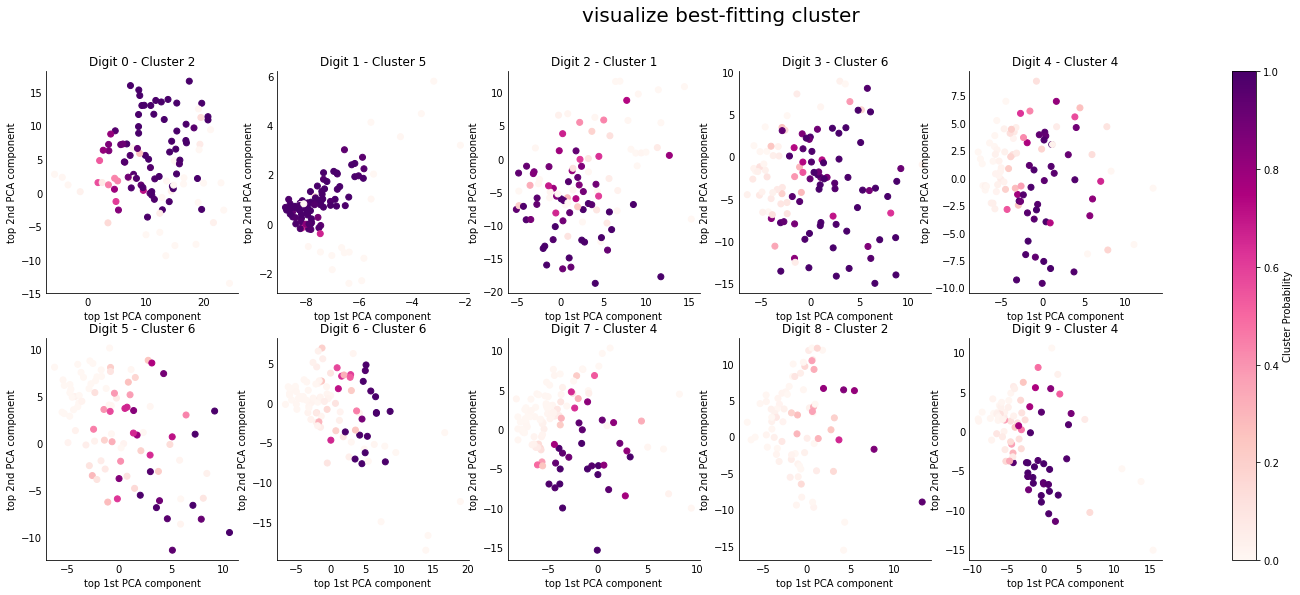

In [51]:
fig, ax = plt.subplots(2, 5, figsize=(25, 9))

classes = np.unique(y_train)

for i, axi in enumerate(ax.flat):
    X2 = X_pca_1000[y_train == classes[i]]
    scatter = axi.scatter(X2[:, 0], X2[:, 1], c=p[i], cmap='RdPu', vmin=0, vmax=1)
    axi.set(title=f'Digit {i} - Cluster {index[i]}', xlabel='top 1st PCA component', ylabel='top 2nd PCA component')
    axi.spines['top'].set_visible(False)
    axi.spines['right'].set_visible(False)
    #axi.set_facecolor('coolwarm')
    axi.tick_params(axis='both', which='both', length=0)

fig.colorbar(scatter, ax=ax.ravel().tolist(), location='right', label="Cluster Probability")
fig.suptitle('visualize best-fitting cluster', size=20)


I give the above scatter plots where each point represents a digit and is coloured according to the probability of belonging to its best-fitting cluster. 

Interpretation of the plot can help us to understand the uncertainty of the clustering. If the points for a given digit are predominantly one colour (i.e. one cluster has a high probability), then the clustering for that digit is more certain. Conversely, if the points are spread across multiple colours (i.e. multiple clusters have similar probabilities), then the clustering for that digit is less certain, and there may be ambiguity in assigning a cluster to that digit.

From the above plots, we can see that for digit 0, 1, 2 , 3, 4 the points are mostly purple, indicating that the clusterings for corresponding digit are more certain. On the other hand, for other digits, the points are spread across multiple colours, indicating that the clusterings for there digits is less certain, and there may be ambiguity in assigning the cluster to those digits.

1.3.4

In [52]:
# get the labels
y_train = original_data.to_numpy()[:1000,0]

np.random.seed(12345)
gmm_5 = GMModel(X_pca_1000,5)

gmm_8 = GMModel(X_pca_1000,8)

gmm_10 = GMModel(X_pca_1000,10)


fitStep(gmm_5,X_pca_1000, max_iter=2000, error=1e-5)
fitStep(gmm_8,X_pca_1000, max_iter=2000, error=1e-5)
fitStep(gmm_10,X_pca_1000, max_iter=2000, error=1e-5)

p_5 = prob_digit(gmm_5, X_pca_1000, y_train)
p_8 = prob_digit(gmm_8, X_pca_1000, y_train)
p_10 = prob_digit(gmm_10, X_pca_1000, y_train)

y_pred_5 = predict(gmm_5, X_pca_1000)
y_pred_8 = predict(gmm_8, X_pca_1000)
y_pred_10 = predict(gmm_10, X_pca_1000)

# the mapping
class_to_cluster_5,index_5 = map(X_pca_1000, gmm_5, y_train)
class_to_cluster_8,index_8 = map(X_pca_1000, gmm_8, y_train)
class_to_cluster_10,index_10 = map(X_pca_1000, gmm_10, y_train)

cluster_labels_mapped_5 = np.array([class_to_cluster_5[c] for c in y_train])
cluster_labels_mapped_8 = np.array([class_to_cluster_8[c] for c in y_train])
cluster_labels_mapped_10 = np.array([class_to_cluster_10[c] for c in y_train])

accuracy_5 = np.mean(cluster_labels_mapped_5 == y_pred_5)
accuracy_8 = np.mean(cluster_labels_mapped_8 == y_pred_8)
accuracy_10 = np.mean(cluster_labels_mapped_10 == y_pred_10)

print(f'5 components best fitting cluster map',class_to_cluster_5)
print(f'8 components best fitting cluster map',class_to_cluster_8)
print(f'10 components best fitting cluster map',class_to_cluster_10)



Converged at 168th iteration


<ipython-input-41-1734a9b8f332>:53: RuntimeWarning: invalid value encountered in true_divide
  weights = numerator / denominator


Converged at 265th iteration
Converged at 231th iteration
class label 0 best-fitting cluster index is 2
class label 1 best-fitting cluster index is 4
class label 2 best-fitting cluster index is 1
class label 3 best-fitting cluster index is 1
class label 4 best-fitting cluster index is 3
class label 5 best-fitting cluster index is 2
class label 6 best-fitting cluster index is 1
class label 7 best-fitting cluster index is 3
class label 8 best-fitting cluster index is 2
class label 9 best-fitting cluster index is 3
class label 0 best-fitting cluster index is 4
class label 1 best-fitting cluster index is 0
class label 2 best-fitting cluster index is 1
class label 3 best-fitting cluster index is 1
class label 4 best-fitting cluster index is 2
class label 5 best-fitting cluster index is 1
class label 6 best-fitting cluster index is 4
class label 7 best-fitting cluster index is 2
class label 8 best-fitting cluster index is 1
class label 9 best-fitting cluster index is 2
class label 0 best-fit

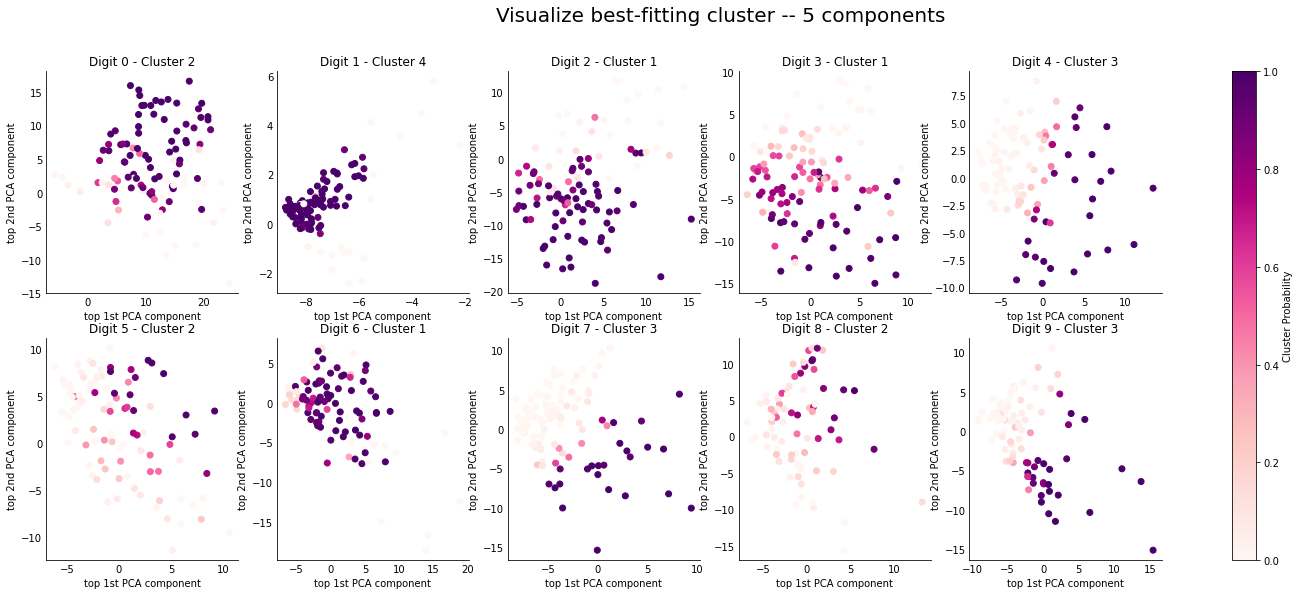

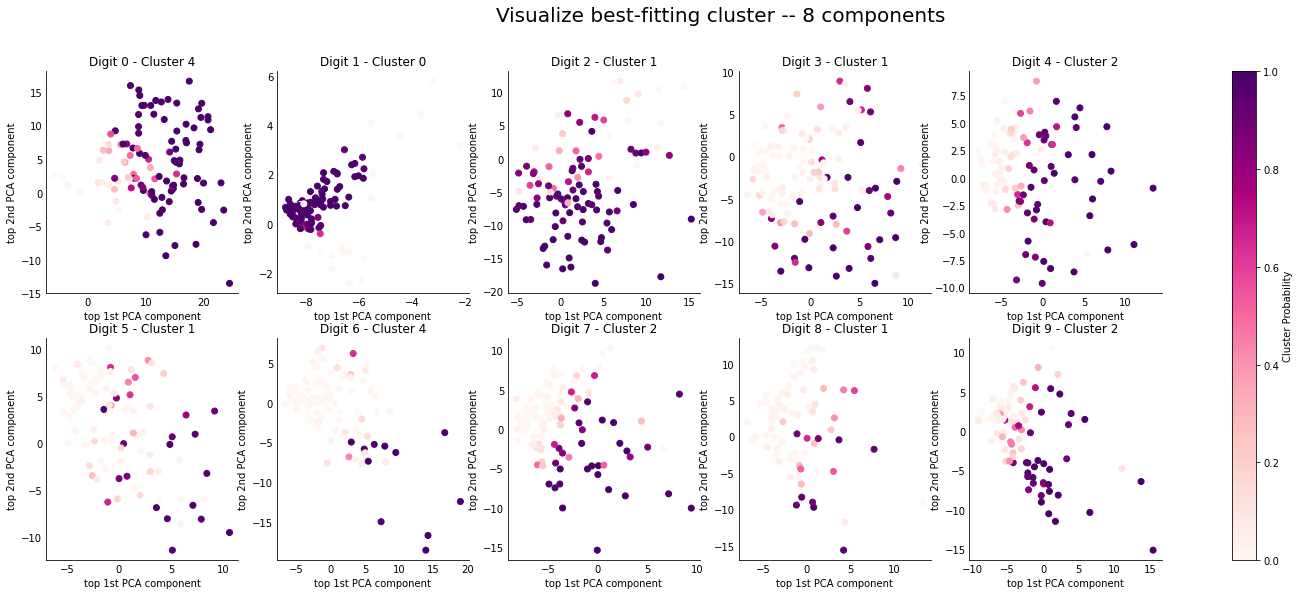

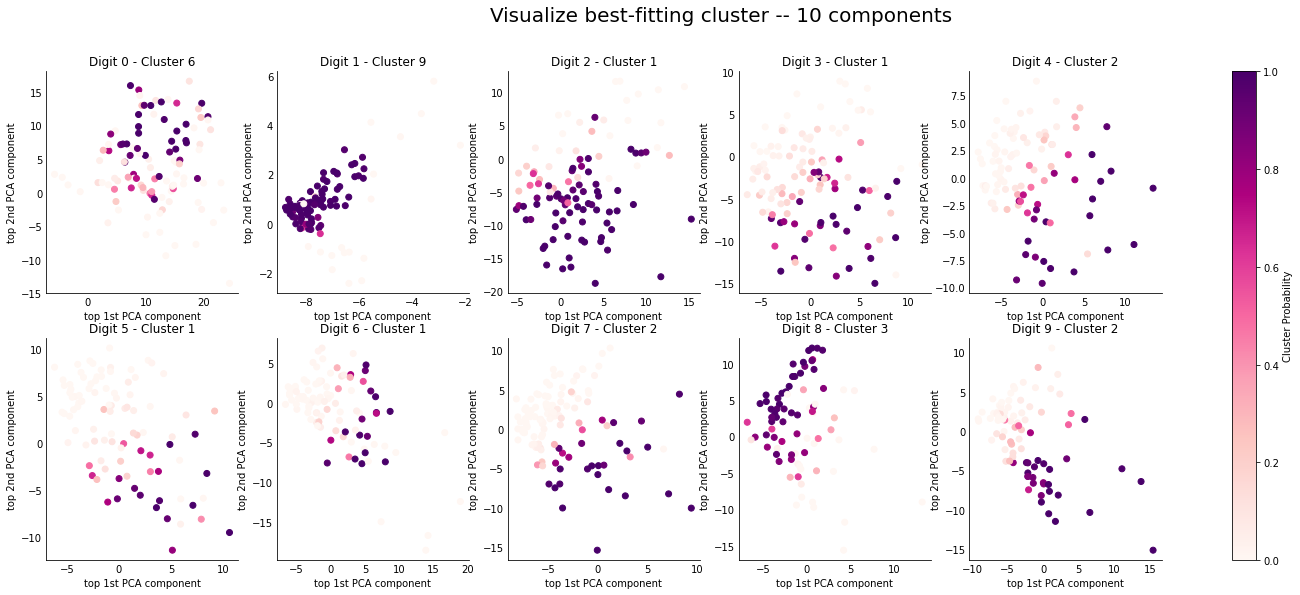

In [53]:
def plot_best_fitting_clusters(X_pca, y_train, cluster_probs, cluster_indices, num_components):
    """
    Plot best-fitting clusters for the given data, probabilities, and indices.
    
    Args:
        X_pca: Data set (numpy array) after PCA transformation
        y_train: Labels for the data set (numpy array)
        cluster_probs: List of probabilities for each class
        cluster_indices: Cluster indices for each class
        num_components: Number of GMM components
    """
    unique_classes = np.unique(y_train)
    
    fig, ax = plt.subplots(2, 5, figsize=(25, 9))
    fig.suptitle(f'Visualize best-fitting cluster -- {num_components} components', size=20)
    
    for i, axi in enumerate(ax.flat):
        X_subset = X_pca[y_train == unique_classes[i]]
        scatter = axi.scatter(X_subset[:, 0], X_subset[:, 1], c=cluster_probs[i], cmap='RdPu', vmin=0, vmax=1)
        axi.set(title=f'Digit {i} - Cluster {cluster_indices[i]}', xlabel='top 1st PCA component', ylabel='top 2nd PCA component')
        axi.spines['top'].set_visible(False)
        axi.spines['right'].set_visible(False)
        axi.tick_params(axis='both', which='both', length=0)
        
    fig.colorbar(scatter, ax=ax.ravel().tolist(), location='right', label="Cluster Probability")
    plt.show()

# Replace these variables with the actual values obtained from your GMM
probabilities = [p_5, p_8, p_10]
indices = [index_5, index_8, index_10]
num_components_list = [5, 8, 10]

for probs, index, num_components in zip(probabilities, indices, num_components_list):
    plot_best_fitting_clusters(X_pca_1000, y_train, probs, index, num_components)


When reducing the number of components in the GMM, we are essentially simplifying the model and forcing the algorithm to assign more data points to fewer clusters. This can result in increased uncertainty in the clustering, as the algorithm may struggle to distinguish between different patterns or variations within the data.

From the results of the best-fitting cluster index, we find many digits maps to same cluster when we only have 5 components. And many clusters are not mapped when we have 10 components.

From the scatter plots, we can see most of digit 0,1,2,3,4,6 are purple points, and they are certain for 5 components. Most of these digit are are purple points, and they are certain for 8 components. By comparing to the plots for 10 components, we can see, 8 components have more certain clustering(digit 0,1,2,3,4,5,7,9) that 10 components, while 5 components have less certain clustering that 10 components. From this we can say, more components to the GMM can result in overfitting, where the model becomes too complex and tries to capture noise or irrelevant features in the data. This can lead to decreased certainty and accuracy in the clustering, as the algorithm may struggle to distinguish between meaningful patterns and random fluctuations in the data. 

In summary, the optimal number of components in the GMM depends on the specific characteristics of the data and the desired level of complexity and interpretability of the model. It's important to balance the trade-off between model complexity and accuracy, and choose a number of components that provides the best balance for the particular application.

### Task 2: Clustering and graph-based analysis (35 marks)

#### 2.1 Clustering (15 marks)
2.1.1

In [54]:
gene_data = pd.read_csv('gene_expression_data.csv')
gene = gene_data.to_numpy()[:, :-1]
gene_type = gene_data.to_numpy()[:, -1]
gene_data 

,Gene 0,Gene 1,Gene 2,Gene 3,Gene 4,Gene 5,Gene 6,Gene 7,Gene 8,Gene 9,...,Gene 86,Gene 87,Gene 88,Gene 89,Gene 90,Gene 91,Gene 92,Gene 93,Gene 94,Type
0,9.796088,0.591871,0.591871,0.000000,11.420571,13.453759,4.411847,5.412334,10.771613,10.225665,...,5.974369,8.086513,12.727750,15.205717,6.438116,6.412577,0.000000,6.814730,13.618145,PRAD
1,10.070470,0.000000,0.000000,0.000000,13.085672,14.531863,10.462298,9.832926,13.520312,13.968046,...,0.000000,0.000000,11.197204,12.993933,10.800746,10.749811,0.000000,11.445610,0.000000,LUAD
2,8.970920,0.000000,0.452595,0.000000,8.263119,9.754908,8.964549,9.948113,8.693773,8.776111,...,3.907160,5.324101,11.487066,13.380596,6.656236,10.209734,0.000000,7.748830,12.759976,PRAD
3,8.524616,1.039419,0.434882,0.000000,10.798520,12.263020,7.440695,8.062343,8.802083,9.237487,...,4.296083,6.959747,12.974639,14.891812,6.030725,7.315648,0.434882,7.117924,12.353276,PRAD
4,8.047238,0.000000,0.000000,0.360982,12.283010,14.033759,8.719180,8.831472,8.462073,8.211202,...,0.000000,0.000000,11.337237,13.390061,5.989593,8.359671,0.000000,6.327545,0.000000,BRCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,7.470358,0.000000,0.000000,0.759497,12.907773,14.055342,6.352628,7.591919,11.388588,11.528142,...,0.000000,0.000000,11.572307,13.265769,9.496432,5.945493,0.000000,10.922889,1.450063,LUAD
796,6.283574,0.000000,0.000000,0.865919,12.353014,13.944694,6.553660,5.665609,8.913329,8.704495,...,0.000000,0.865919,11.375458,13.312075,7.116490,6.105469,0.000000,8.069933,0.000000,BRCA
797,8.113409,0.000000,0.000000,0.000000,11.496739,13.107654,8.662768,7.926272,10.260531,10.548620,...,0.000000,1.380896,12.404003,14.256452,7.531046,8.541708,0.000000,7.963838,12.987499,LUAD
798,7.439839,1.002595,0.000000,0.000000,11.119304,12.694582,10.221986,9.822217,10.339505,10.202454,...,0.586693,0.586693,11.445589,13.392961,10.384071,10.799249,4.049317,12.538691,11.204602,COAD


Based on the ratio of the between cluster scatter matrix (BCSM) to the inside cluster scatter matrix (WCSM), the CH index is calculated:
$$CH_k = \frac{BCSM}{k-1} \cdot \frac{n-k}{WCSM} $$
where $n$ is the total number of points and $k$ the number of clusters. 

The BCSM is based on the separation of clusters and is described as follows:
$$BCSM=\sum^k_{i=1}n_i \cdot d(z_i,z_{tot})^2$$ 
where $z_i$ is the center of cluster $c_i$ and $n_i$, the number of points in c_i. 

The following is the WCSM:
$$ WCSM = \sum^{k}_{i=1} \sum_{x \in c_i} d(x,z_i)^2 $$
where $x$ is a data point belonging to cluster $c_i$.

BCSM is maximised and WCSM is minimised to produce clusters that are evenly spaced apart and compact. The largest value for CH therefore denotes a good partition for the data set..

In [55]:
def k_means_al(X, k, max_iter, pr=True):
    # the kmeans algorithm
    n_samples, n_features = X.shape
    
    # labels: assign every sample to a cluster at random
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)
    
    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        # Find data points belonging to cluster i
        cluster_points = [x for x in X_labels if x[-1]==i]
        if cluster_points:
            # Compute centroid for cluster i
            centroids[i] = np.mean(cluster_points, axis=0)[0:n_features]
        else:
            # No data points in cluster i, use previous centroid value
            centroids[i] = centroids[i-1]
        
    difference = 0
    new_labels = np.zeros(len(X))
    # k-means algorithm
    for i in range(max_iter):
        if pr == True:
            print('Iteration:', i)
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            if pr == True:
                print('Labels unchanged! Terminating k-means.')
                break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels) 
            if pr == True:   
                print('%4f%% labels changed' % (difference * 100))
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    return labels, centroids
                    

In [56]:
gene = gene.astype('float64')

In [57]:
def calinski_index(X, labels):
    """Calculate the Calinski-Harabasz index for a given clustering."""
    '''
    X: input data, shape(N, 95)
    labels: get from kmeans algorithm, shape(N,)
    
    returns: Calinski-Harabasz index, a scalar
    '''
    
    # Get the number of clusters and the number of samples and features
    n_clusters = len(np.unique(labels))
    n_samples, n_features = X.shape
    
    # Calculate the centroids of each cluster
    centroids = np.zeros((n_clusters, n_features))
    for i in range(n_clusters):
        mask = labels == i
        centroids[i] = np.mean(X[mask], axis=0)
    
    # Calculate the within-cluster scatter matrix(WCSM)
    WCSM = 0
    for i in range(n_clusters):
        mask = labels == i
        cluster_size = np.sum(mask)
        if cluster_size > 1:
            cluster_scatter = np.sum((X[mask] - centroids[i])**2, axis=0)
            WCSM += np.sum(cluster_scatter)
    
    # Calculate the between-cluster scatter matrix(BCSM)
    total_mean = np.mean(X, axis=0)
    BCSM = 0
    for i in range(n_clusters):
        mask = labels == i
        cluster_size = np.sum(mask)
        if cluster_size > 1:
            cluster_mean = np.mean(X[mask], axis=0)
            BCSM += cluster_size * np.sum((cluster_mean - total_mean) ** 2)
    
    # Calculate the Calinski-Harabasz index
    ch_score = (BCSM / (n_clusters - 1)) / (WCSM / (n_samples - n_clusters))
    
    return ch_score


the Calinski-Harabasz index can be used to compare the quality of different clustering algorithms or to select the number of clusters in a given dataset. A higher index value indicates better clustering performance, meaning that the clusters are well separated from each other and the within-cluster variance is small. Conversely, a lower index value indicates poor clustering performance, meaning that the clusters are not well separated and/or the within-cluster variance is high.

In [58]:
k_list = np.arange(2, 15, 1)
label_list = []
for i in k_list:
    l5 = []
    for j in range(5):
        l, centroids = k_means_al(gene, i, max_iter= 100)
        l5.append(l)
    label_list.append(l5)
label_l = np.array(label_list)

Iteration: 0
47.625000% labels changed
Iteration: 1
7.750000% labels changed
Iteration: 2
1.625000% labels changed
Iteration: 3
0.750000% labels changed
Iteration: 4
0.125000% labels changed
Iteration: 5
Labels unchanged! Terminating k-means.
Iteration: 0
47.750000% labels changed
Iteration: 1
25.375000% labels changed
Iteration: 2
8.125000% labels changed
Iteration: 3
3.375000% labels changed
Iteration: 4
4.500000% labels changed
Iteration: 5
2.125000% labels changed
Iteration: 6
Labels unchanged! Terminating k-means.
Iteration: 0
45.375000% labels changed
Iteration: 1
17.250000% labels changed
Iteration: 2
14.875000% labels changed
Iteration: 3
15.500000% labels changed
Iteration: 4
4.750000% labels changed
Iteration: 5
3.625000% labels changed
Iteration: 6
4.125000% labels changed
Iteration: 7
4.250000% labels changed
Iteration: 8
0.875000% labels changed
Iteration: 9
Labels unchanged! Terminating k-means.
Iteration: 0
46.625000% labels changed
Iteration: 1
3.250000% labels changed


In [59]:
ch_score_list = []
for i in range(len(label_l)):
    ch_score5 = []
    for j in range(len(label_l[i])):
        score = calinski_index(gene, label_l[i][j])
        ch_score5.append(score)
    ch = np.mean(ch_score5)
    ch_score_list.append(ch)
index = np.argmax(ch_score_list)
optimal_k = k_list[index]
print('optimal k with largest Calinski-Harabasz index is:',optimal_k)

optimal k with largest Calinski-Harabasz index is: 4


/Users/zhuyining/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhuyining/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


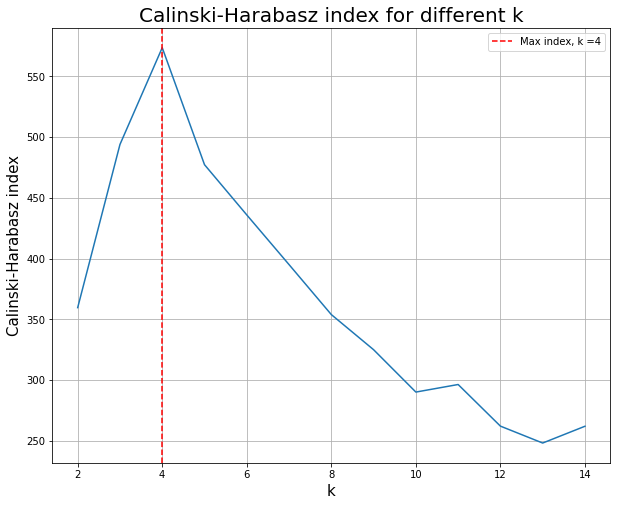

In [60]:
"""Plot the Calinski-Harabasz index for different values of k."""
    
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(k_list, ch_score_list)
ax.set_xlabel('k', size=15)
ax.set_ylabel('Calinski-Harabasz index', size=15)
ax.axvline(k_list[np.argmax(ch_score_list)], color='red', linestyle='--', label='Max index, k =4')
ax.set_title('Calinski-Harabasz index for different k', size=20)
ax.legend()
plt.grid()
plt.show()

In [61]:
labels, centroids = k_means_al(gene, k=optimal_k, max_iter=15)
cluster_sizes = np.bincount(labels)
print("Cluster sizes:", cluster_sizes)

Iteration: 0
71.250000% labels changed
Iteration: 1
26.250000% labels changed
Iteration: 2
11.125000% labels changed
Iteration: 3
10.625000% labels changed
Iteration: 4
2.375000% labels changed
Iteration: 5
0.125000% labels changed
Iteration: 6
Labels unchanged! Terminating k-means.
Cluster sizes: [135 143 122 400]


The optimal k is obtained at the highest Calinski-Harabasz index, here the optimal k is k =4, where the Calinski-Harabasz index is about 573.555. And we also get the size of each cluster: 401, 135, 124 and 140.

2.1.2

In [62]:
def homogeneity(y_true, y_pred):
    """
    Compute the homogeneity score between two label assignments.
    
    Parameters:
    - y_true (array-like, shape=(n_samples,)): The true labels.
    - y_pred (array-like, shape=(n_samples,)): The predicted labels.
    
    Returns:
    - score (float): The homogeneity score.
    """
    
    # Compute the number of unique labels in y_true and y_pred
    n_classes = len(np.unique(y_true))
    n_clusters = len(np.unique(y_pred))
    
    # Compute the contingency matrix
    contingency = np.zeros((n_classes, n_clusters))
    for i in range(len(y_true)):
        contingency[y_true[i], y_pred[i]] += 1
    
    # Compute the marginal sums of the contingency matrix
    row_sum = np.sum(contingency, axis=1)
    col_sum = np.sum(contingency, axis=0)
    
    # Compute the numerator
    hc = -np.sum(row_sum / len(y_true) * np.log(row_sum / len(y_true)))
    
    # Compute the denominator
    hck = 0
    for j in range(n_clusters):
        pj = col_sum[j] / len(y_pred)
        for i in range(n_classes):
            pij = contingency[i, j] / len(y_pred)
            if pij > 0:
                hck -= pij * np.log(pij / pj)

    homogeneity = 1 - hck / hc
    
    return homogeneity


This is an implementation of the homogeneity score in Python using numpy. The function takes in two numpy arrays, y_true and y_pred, that represent the true labels and the predicted labels, respectively. The function first computes the contingency matrix that represents the number of samples that belong to both a true label and a predicted label. It then computes the marginal sums of the contingency matrix, which are used to compute the entropy of the true labels and the entropy of the clusters. The mutual information is computed using the contingency matrix, and the homogeneity score is computed by dividing the mutual information by the entropy of the true labels.

The homogeneity score is a measure of how well the clusters match the true labels. A score of 1.0 indicates perfect homogeneity, meaning that each cluster contains only samples that belong to a single true label. A score of 0.0 indicates that the clustering is completely random with respect to the true labels.

In [63]:
gene_type = gene_data.to_numpy()[:, -1]
gene_type = gene_type.astype(str)
# Get the unique non-numeric values
non_numeric_values = np.unique(gene_type[~np.char.isdigit(gene_type)])

# Replace each non-numeric value with a unique integer value
gene_type_numeric = np.copy(gene_type)
for i, value in enumerate(non_numeric_values):
    gene_type_numeric[gene_type_numeric == value] = i

# Convert the array to integers
gene_type_int = gene_type_numeric.astype('int32')


In [64]:
labels_pred, centroids = k_means_al(gene, k=4, max_iter=100)

Iteration: 0
69.875000% labels changed
Iteration: 1
11.500000% labels changed
Iteration: 2
4.875000% labels changed
Iteration: 3
1.000000% labels changed
Iteration: 4
0.125000% labels changed
Iteration: 5
Labels unchanged! Terminating k-means.


In [65]:
homogeneity(gene_type_int, labels_pred)

0.6653242487126452

In the case of tumor types, homogeneity score measures how well the clustering algorithm groups samples that belong to the same tumor type together. A high homogeneity score indicates that the clustering algorithm has successfully grouped together samples of the same tumor type, while a low score suggests that the algorithm may have mixed up samples from different tumor types.

Our homogeneity score result is about 0.6653. It suggests that the clustering algorithm has moderately successfully grouped together samples that belong to the same tumor type. However, there is still room for improvement as there may be some mixing up of samples from different tumor types.

#### 2.2 Graph-based analysis (20 marks)
2.2.1

In [66]:
gene_data = pd.read_csv('gene_expression_data.csv')
gene = gene_data.iloc[:, :-1]
X = gene.to_numpy()
X.shape 

(800, 95)

In [67]:
def adj_matrix(X):
    # defining an empty adjacency matrix
    corr_matrix = np.corrcoef(X.T)
    
    # fill the diagonal with zeros
    np.fill_diagonal(corr_matrix,0)

    # add edges for each pair of genes with a correlation coefficient above a certain threshold
    threshold = 0.75
    # set entries with absolute value smaller than 0.75 to zero
    corr_matrix[np.abs(corr_matrix) < threshold] = 0

    return corr_matrix

In [68]:
a = adj_matrix(X)

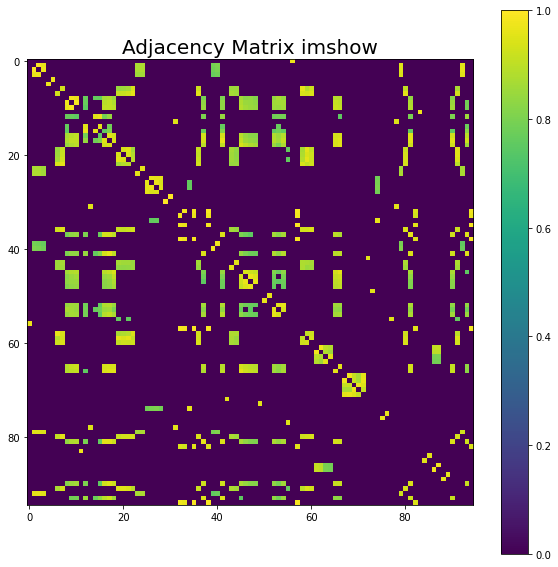

In [69]:
# plot a heatmap of the distance matrix
plt.figure(figsize=(10,10))
c = plt.imshow(a)
plt.title('Adjacency Matrix imshow', size = 20)
plt.colorbar(c);

2.2.2

Simple degree centrality is a way to gauge a node's significance. The equation is: $c_d=\frac{d}{2E}=\frac{A1}{2E}$.

In [70]:
def deg_central(A, pr = True):
    
    # define diagonal matrix of node degrees
    weighted_degree = A.sum(axis=1) 
    
    c_d = weighted_degree/(2*0.5*np.sum(weighted_degree))
    
    # Sort genes in descending order by degree centrality
    sorted_genes = np.argsort(c_d)[::-1]
    
    if pr== True:
        # Print top 5 ranking genes
        print(f"Top 5 ranking genes by degree centrality: {sorted_genes[:5]}")

    return c_d

In [71]:
# Replace 'a' with the actual adjacency matrix
adj_matrix = a

# Compute degree centrality and find the top 5 ranking genes
degree_centrality_values = deg_central(adj_matrix)
top5_genes = np.argsort(degree_centrality_values)[::-1][:5]
top5_genes_values = degree_centrality_values[top5_genes]

print(f"Top 5 genes degree centrality values: {top5_genes_values}")


Top 5 ranking genes by degree centrality: [17 41 16 81 90]
Top 5 genes degree centrality values: [0.02687344 0.02593545 0.02537837 0.02523066 0.02487023]


2.2.3

We can also construct the symmetric normalized Laplacian,

$$
\boldsymbol L = \boldsymbol I - \boldsymbol D^{-1/2}\boldsymbol A \boldsymbol D^{-1/2}
$$ 


In [72]:
def norm_laplacian(A):
    
    # define diagonal matrix of node degrees
    weighted_degree = A.sum(axis=1) 
    
    # computing inverse square root vector of degree
    weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)
    
    # set a diagonal matrix of the inverse square root of degree
    D_inv_sqrt = np.diag(weighted_degree_sqrt)
    
    # define the normalised Laplacian
    L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))
    
    # Check for invalid values
    if not np.isfinite(L_norm).all():
        L_norm = np.where(np.isfinite(L_norm), L_norm, 0)
    
    # Compute eigenvalues and eigenvectors of Laplacian matrix
    eigvals, eigvecs = np.linalg.eig(L_norm)

    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx].real
    eigvecs = eigvecs[:, idx].real
   
    return L_norm, eigvals, eigvecs

In [73]:
L_norm,evals_sorted,eve_sorted = norm_laplacian(a)
evals_sorted.shape, eve_sorted.shape, L_norm.shape

((95,), (95, 95), (95, 95))

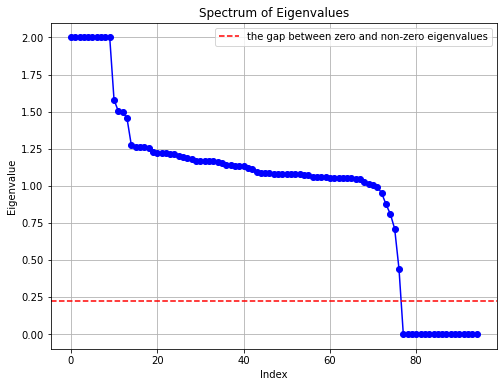

In [74]:
# Find gap between zero and non-zero eigenvalues
zero_mask = np.isclose(evals_sorted, 0)
r = np.count_nonzero(zero_mask)
gap = (evals_sorted[-r-1]+evals_sorted[-r])/2

# Plot spectrum of eigenvalues with gap
plt.figure(figsize=(8,6))
plt.plot(evals_sorted, 'o-', color = 'b', )
plt.axhline(y=gap, color='r', linestyle='--', label = 'the gap between zero and non-zero eigenvalues')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Spectrum of Eigenvalues')
plt.legend()
plt.grid()
plt.show()


The normalized Laplacian matrix of a graph can be used to gain insights into the connectivity of the graph. If the graph is connected, then the number of zero eigenvalues of the normalized Laplacian matrix is 1. If the graph has multiple connected components, then the number of zero eigenvalues is greater than 1, and the value of r corresponds to the number of connected components in the graph.

In this case, the value of r is 18, indicating that the graph has 18 connected subgraphs. The gap between the zero and non-zero eigenvalues in the spectrum of eigenvalues of the normalized Laplacian matrix provides information about the separation between the different components of the graph. A larger gap indicates a greater separation between the components, while a smaller gap indicates a closer proximity between the components.

n summary, the number of zero eigenvalues of the normalized Laplacian matrix tells us about the connectivity of the graph, while the gap between the zero and non-zero eigenvalues in the spectrum of eigenvalues provides information about the number of connected components and their separation in the graph. By analyzing the eigenvalues of the normalized Laplacian matrix, we can gain valuable insights into the structure and connectivity of a graph.

2.2.4

$$
T_{ij} = U_{ij}/ \sqrt{\sum_k U_{ik}^2}
$$
$$
W(\mathcal{C}) =\frac{1}{2}\sum_{l=1}^k \frac{1}{|c_l|}\sum_{i,j\in c_l}\parallel x^{(i)}-x^{(j)} \parallel ^{2}
$$

In [75]:
def within_cluster_distance(X, labels, k):
    nwd = np.zeros(k)
    for m in range(k):
        cluster = X[labels == m]
        N = len(cluster)
        if N > 1:
            distances = np.sum(np.linalg.norm(cluster[:, np.newaxis] - cluster, axis=2)**2) / (2 * N)
            nwd[m] = distances
    return np.sum(nwd)

def wcd(X, k, iterations=100):
    W = []
    for _ in range(iterations):
        labels, _ = k_means_al(X, k, max_iter=100, pr=False)
        dist = within_cluster_distance(X, labels, k)
        W.append(dist)
    index = np.argmin(np.array(W))
    dis = W[index]
    return dis


def elbow(X):
    # Initialize an array to store the within-cluster sum of squares for each value of k
    wc = []
    # Loop over values of k
    for k in range(2, 40):
        # Apply the k-means algorithm to the data for this value of k
        wd = wcd(X, k)
        wc.append(wd)
    # Plot the WCSS values against k
    plt.plot(range(2, 40), wc,'.-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Within-cluster sum of squares')
    plt.title('Elbow curve')
    plt.grid()
    plt.show()
    
    return wc

In [76]:
# Extract eigenvectors corresponding to zero eigenvalues
U = eve_sorted[:, -r:]
# Compute L2-norm of each row of U
norms = np.linalg.norm(U, axis=1)
# Divide each row of U by its norm to obtain normalized matrix T
T = U / (norms[:, np.newaxis]+1e-25)


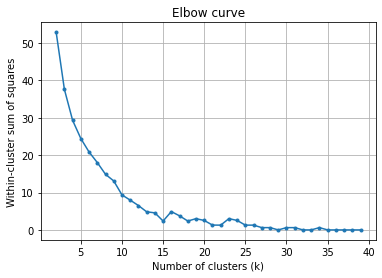

In [77]:
wc_sum = elbow(T)

In [78]:
k = 19 # this is the best k in elbow
cluster_labels, _= k_means_al(T, k, max_iter=100)
print(f'cluster at the optimal k is: {cluster_labels}')
np.bincount(cluster_labels)

Iteration: 0
82.105263% labels changed
Iteration: 1
Labels unchanged! Terminating k-means.
cluster at the optimal k is: [ 9 16 16 16  7  7  3  3  1  1  1  3  1  6  1  1  1  1  1  3  3  3  3 16
 16  8  8  8  8  5  5  6 12 12  8 12  3  1 12 16 16  1  9  3  3  1  1  1
  1 13  8  8  1  1  1  3  9 12  3  3  3 12 12 12 12  1  1 12 12 12 12 12
  9 13  8 13 13  3  6 16  3  1 12  3  9  9 12 12 15 15  1  3 16  1 12]


array([ 0, 23,  0, 18,  0,  2,  3,  2,  8,  6,  0,  0, 18,  4,  0,  2,  9])

The elbow point is typically the point at which the curve starts to level off. So I choose k=19. 

Observing the cluster:

-Cluster 1 appears to be the largest cluster, with many samples assigned to it.

-Clusters 0 and 2, 4, 10, 11,14 are missing, suggesting that there were no samples that were similar enough to each other to be grouped together in these clusters.

-Clusters 3, 12 also contain a significant number of samples, but are smaller than cluster 1.

-Other clusters have even fewer samples assigned to them, indicating that these samples have unique characteristics that distinguish them from the rest of the data.

So a few dominant groups of samples that share common characteristics, as well as some smaller clusters that represent more distinct subsets of the data. 


2.2.5

In [79]:
gene_data = pd.read_csv('gene_expression_data.csv')
gene = gene_data.iloc[:, :-1]
X = gene.to_numpy()
def adj_matrix(X):
    # defining an empty adjacency matrix
    corr_matrix = np.corrcoef(X.T)
    
    # fill the diagonal with zeros
    np.fill_diagonal(corr_matrix,0)

    # add edges for each pair of genes with a correlation coefficient above a certain threshold
    threshold = 0.75
    # set entries with absolute value smaller than 0.75 to zero
    corr_matrix[np.abs(corr_matrix) < threshold] = 0

    return corr_matrix

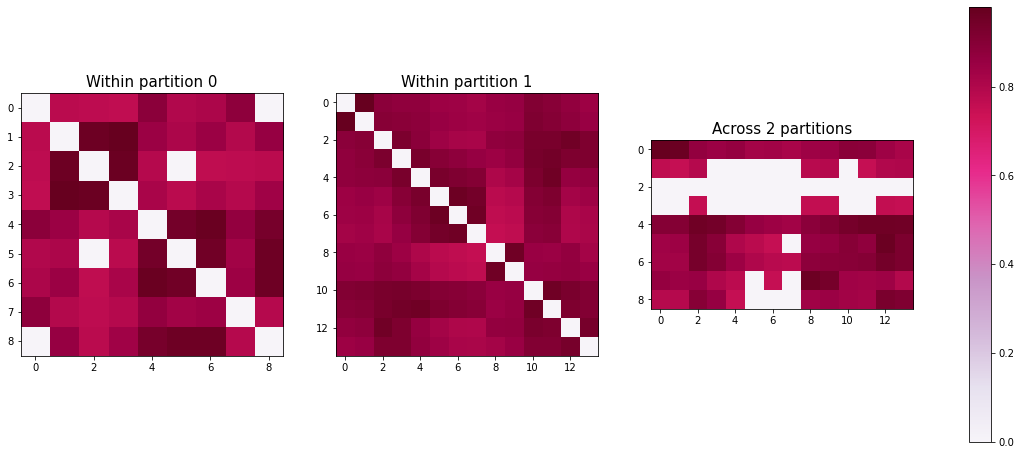

In [80]:
# Find the largest connected component
component_sizes = np.bincount(cluster_labels)
largest_component_label = np.argmax(component_sizes)
largest_component_data = X[:, cluster_labels == largest_component_label]

# Compute adjacency matrices
subgraph_adj_matrix = adj_matrix(largest_component_data)
normalized_laplacian, eigenvalues, eigenvectors = norm_laplacian(subgraph_adj_matrix)

# Extract the second eigenvector and create the spectral partition
second_eigenvector = eigenvectors[:, -2]
spectral_partition = second_eigenvector.copy()
spectral_partition[spectral_partition < 0] = 0
spectral_partition[spectral_partition > 0] = 1

# Get the indices of partition 0 and 1
largest_component_indices = np.where(cluster_labels == largest_component_label)[0]
partition0_indices = largest_component_indices[spectral_partition == 0]
partition1_indices = largest_component_indices[spectral_partition == 1]

# Compute adjacency matrices for partition 0, partition 1, and between partitions
fullgraph_adj_matrix = adj_matrix(X)
partition0_adj_matrix = fullgraph_adj_matrix[np.ix_(partition0_indices, partition0_indices)]
partition1_adj_matrix = fullgraph_adj_matrix[np.ix_(partition1_indices, partition1_indices)]
across_partitions_adj_matrix = fullgraph_adj_matrix[np.ix_(partition0_indices, partition1_indices)]

def plot_adjacency_matrices(matrices, titles):
    """
    Plot adjacency matrices with the given titles.
    
    Args:
        matrices: List of adjacency matrices to plot
        titles: List of titles for each adjacency matrix
    """
    fig, axes = plt.subplots(nrows=1, ncols=len(matrices), figsize=(20, 8))
    
    for ax, matrix, title in zip(axes, matrices, titles):
        img = ax.imshow(matrix, cmap='PuRd')
        ax.set_title(title, size=15)
    
    fig.colorbar(img, ax=axes.ravel().tolist())
    plt.show()

matrices_to_plot = [partition0_adj_matrix, partition1_adj_matrix, across_partitions_adj_matrix]
titles_to_plot = ['Within partition 0', 'Within partition 1', 'Across 2 partitions']

plot_adjacency_matrices(matrices_to_plot, titles_to_plot)


These patterns provide insights into the connectivity and structure of the network.

In Within partition 0, we can see that the diagonal and a few off-diagonal elements are dark while other off-diagonal elements are light. This suggests that there are strong connections between nodes within the same partition, which is expected for a well-defined partition. However, there are relatively weak connections between nodes in different partitions, indicating a clear separation between the two subnetworks.

In Within partition 1, we can see that the diagonal elements are dark and the off-diagonal elements are light. This indicates that the nodes within partition 1 are densely connected with each other, while there are relatively fewer connections between nodes in partition 1 and nodes in partition 0. This suggests that there may be some distinct subgroups within the biggest cluster, with stronger connections between nodes within each subgroup compared to those between different subgroups. This can provide insights into the functional organization of the network and the specific roles played by different nodes within each subgroup.

In Across partitions, we can see that the diagonal elements are light, indicating weak connections between nodes in the same partition. The off-diagonal elements are dark, indicating strong connections between nodes in different partitions. This suggests that the nodes across the two partitions have strong connections with each other, indicating that there may be some overlap between the two subnetworks. This can provide insights into the overall integration of the network and the communication pathways between different functional subnetworks.

2.2.6

In [81]:
fullgraph_adj_matrix = a

In [82]:
# Compute the degree centrality for the subgraph and full graph
degree_centrality_subgraph = deg_central(subgraph_adj_matrix, pr=False)
index_subgraph_adj_matrix= np.array([largest_component_indices[i] for i in np.argsort(degree_centrality_subgraph)[::-1][:5]])
sorted_genes_a3 = np.sort(degree_centrality_subgraph)[::-1][:5]
sorted_genes_a3

array([0.05289032, 0.05104425, 0.04994785, 0.04965714, 0.04894775])

In [83]:
degree_centrality_fullgraph = deg_central(fullgraph_adj_matrix)
sorted_genes_a = np.sort(degree_centrality_fullgraph )[::-1][:5]
print('Top 5 ranking genes by degree centrality for subgraph:', index_subgraph_adj_matrix)


Top 5 ranking genes by degree centrality: [17 41 16 81 90]
Top 5 ranking genes by degree centrality for subgraph: [17 41 16 81 90]


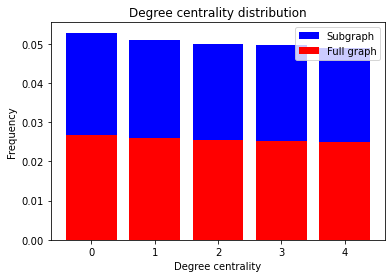

In [84]:
def plot_degree_centrality_distribution(subgraph_centrality, fullgraph_centrality):
    """
    Plot degree centrality distribution for subgraph and full graph.
    
    Args:
        subgraph_centrality: Degree centrality values for the subgraph
        fullgraph_centrality: Degree centrality values for the full graph
    """
    plt.bar(range(len(subgraph_centrality)), subgraph_centrality, label='Subgraph', color='b')
    plt.bar(range(len(fullgraph_centrality)), fullgraph_centrality, label='Full graph', color='r')
    
    plt.xlabel('Degree centrality')
    plt.ylabel('Frequency')
    plt.title('Degree centrality distribution')
    plt.legend()
    plt.show()

# Call the plotting function
plot_degree_centrality_distribution(sorted_genes_a3, sorted_genes_a)

The top 5 ranking genes by degree centrality for the full graph and the subgraph are the same, it suggests that the biggest cluster of the subgraph is highly interconnected and shares many of the same highly connected genes as the full graph. 

We can observe that the degree centrality distribution of the subgraph is towards higher values compared to the full graph.(i.e.0.05>0.025). This suggests that the nodes in the biggest cluster of the subgraph are more connected to each other than to the nodes outside of the cluster in the full graph. This is expected since the subgraph was constructed by selecting the nodes that are densely connected to each other in the full graph.

## Task 3: Mastery component  (25 marks)

**Please delete this section if you are not a master student**



#### 3.1 Betweenness Centrality (10 marks)
3.1.1

Betweenness centrality is a measure of the importance of a node in a network. It is based on the number of shortest paths that pass through a particular node. The betweenness centrality of a node can be calculated using the following formula:

$$C_B(v) = \sum_{s \neq v \neq t}\frac{\sigma_{st}(v)}{\sigma_{st}}$$

In this formula:

$C_B(v)$ represents the betweenness centrality of node $v$.
$\sigma_{st}$ denotes the total number of shortest paths between nodes $s$ and $t$.
$\sigma_{st}(v)$ represents the number of shortest paths between nodes $s$ and $t$ that pass through node $v$.
The sum is taken over all pairs of nodes $s$ and $t$ in the network, excluding node $v$.
By calculating the betweenness centrality for each node in a network, we can determine which nodes are most central in terms of the flow of information or influence. A higher betweenness centrality value indicates a more central position in the network.

In [85]:
from collections import deque
def betweenness_centrality(A):
    '''Implements Brandes' algorithm for computing betweenness centrality in unweighted and undirected graphs.
    Input: an adjacency matrix `A` of size `n x n` where `n` is the number of nodes
    Output: a vector of betweenness centralities `bc` of length `n`
    Remark:
    If `sigma(i, j)` is the number of shortest paths from node `i` to node `j`, and `sigma(i, j | k)` is the 
    number of those shortest paths that pass through node `k`, then define the ratio 
            `delta(i, j | k) = sigma(i, j | k)/sigma(i, j)`
    and its agcgregation over target nodes `j` as
            `delta(i | k) = \sum_j delta(i, j | k)`
    and further aggregation over source nodes `i` as the betweenness centrality of node `k`
            `bc(k) = \sum_i delta(i | k)`
    Brandes (2001) provides an efficient algorithm of estimating aggregated ratios `delta(i | k)` via breadth
    first search (BFS) and dynamic programming (DP). 
    See https://doi.org/10.1080/0022250X.2001.9990249
    '''
    
    ## FILL WHERE YOU SEE DOTS ##
    
    # some input checking for undirected unweighted graphs
    ## Input checking for undirected unweighted graphs
    
    # check if matrix is square
    n, m = A.shape
    if n != m:
        raise ValueError("Matrix is not square.")
        
    # check if matrix is symmetric
    if not np.allclose(A, A.T):
        raise ValueError("Matrix is not symmetric.")
        
    # check if matrix is binary
    if not np.array_equal(np.unique(A), [0, 1]):
        raise ValueError("Matrix is not binary.")
    
    if not np.allclose(np.diagonal(A), 0):
        raise ValueError("diagonal is not 0.")
    
    # number of nodes
    n = A.shape[0]
    
    # initialise a vector of betweenness centrality for all nodes
    bc = np.zeros(n)
    
    # for every node `i` compute its contribution to the betweenness centrality of all other nodes
    for i in range(n):
        # compute the lengths and counts of shortest paths from `i` to all other nodes via breadth first search (BFS)
         # initialise a stack of nodes that have been visited in the BFS
        S = []
        
        # initialise the queue of nodes that will be visited in the BFS
        Q = [i]
        Q = deque(Q)
        
        # initialise the list of nodes that precede `j` on a shortest path from `i` to every node `j`
        P = [[] for _ in range(n)]       
        
        # initialise the length of shortest paths, a.k.a. "distance", from `i` to every node `j`
        d = [-1] * n
        d[i] = 0
        
        # initialise the number of shortest paths from `i` to every node `j`
        sigma = np.zeros(n)
        sigma[i] = 1
        
        
        # perform BFS until all nodes that are reachable from `i` have been reached
        while Q: 
            
            # pop the next node `k` from the queue to be visited
            k = Q.popleft()
            
            # push to the stack of visited nodes
            S.append(k)
            
            # for each node `j` that is a neighbour of node `k`
            for j in range(n):
                
                # if node `j` has been encountered for the first time
                if A[k][j] and d[j] == -1:
                    
                    # push `j` to the queue of nodes to be visited
                    Q.append(j) 
                    
                    # update the distance from `i` to `j`
                    d[j] = d[k] + 1
                    
                # if node `k` immediately precedes node `j` on a shortest path from `i` to `j`    
                if A[k][j] and d[j] == d[k] + 1: 
                    
                    # update the number of shortest paths from `i` to `j`   
                    sigma[j] += sigma[k]
                    
                    # include `k` in the list of nodes that immediately precede `j` on shortest paths from `i` to `j`
                    P[j].append(k)
                    
        # accumulate aggregated ratios via dynamic programming (DP)
        # initialise aggregated ratios
        delta = np.zeros(n)
        
        # iterate over each vertex in the reverse order of being visited i.e. nodes farthest from `i` first
        while S: 
            
            # pick the most recently visited node `j` from the stack
            j = S.pop()
            
            # go through the list of all nodes `k` that precede `j` on the shortest path from `i` to `j`
            for k in P[j]: 
                
                # update aggregated ratios of `k` using the key result in Theorem 6 of Brandes (2001)
                delta[k] += (sigma[k] / sigma[j]) * (1 + delta[j])
            
            # update the contribution of shortest paths from `i` to the betweenness of node `j`
            if j!= i: 
                bc[j] += delta[j]
    
    # correct for undirected networks
    bc = bc/2
    
    return bc

In [86]:
gene_data = pd.read_csv('gene_expression_data.csv')
gene = gene_data.iloc[:, :-1]
X = gene.to_numpy()

We set all the non-zero elements in the A2, A3 matrix to 1. 

In [87]:
# Convert a weighted adjacency matrix to a binary adjacency matrix.
A2 = a
A2[A2 != 0] = 1

A3 = subgraph_adj_matrix
A3[A3!=0] = 1

#computes the degree centrality of the graph represented by the binary adjacency matrix A3
c_d_a3_2 = deg_central(A3, pr=False)
# sorted indices array to get the indices of the top 5 nodes with the highest degree centrality.
index_a3_2 = np.array([largest_component_indices[i] for i in np.argsort(c_d_a3_2)[::-1][:5]])

In [88]:
# Compute the degree centrality of the graph represented by the binary adjacency matrix A2
c_d = deg_central(A2)
print('Top 5 ranking genes by degree centrality for subgraph without weight:', index_a3_2)
# Compute the betweenness centrality for nodes in the graph represented by the binary adjacency matrix A2
bc1 = betweenness_centrality(A2)
# Sort genes in descending order by betweenness centrality
sorted_genes2 = np.argsort(bc1)[::-1]
# Print top 5 ranking genes
print(f"Top 5 ranking genes by betweenness centrality: {sorted_genes2[:5]} without weight")
bc2 =betweenness_centrality(A3)
# Sort genes in descending order by betweenness centrality
sorted_genes_lcc = np.argsort(bc2)[::-1]
index3 = np.array([largest_component_indices[i] for i in np.argsort(bc2)[::-1][:5]])
# Print top 5 ranking genes
print(f"Top 5 ranking genes by betweenness centrality for subgraph: {index3} without weight")

Top 5 ranking genes by degree centrality: [17 41 90 52 81]
Top 5 ranking genes by degree centrality for subgraph without weight: [17 41  8 81 54]
Top 5 ranking genes by betweenness centrality: [55 21 19 91 17] without weight
Top 5 ranking genes by betweenness centrality for subgraph: [17 41  8 53 93] without weight


I have four sets of top 5 ranking genes (nodes) based on different centrality measures and graph representations. These are the top 5 genes in terms of degree centrality and betweenness centrality for the original graph and its subgraph. Both centrality measures were calculated without considering the edge weights in the graph.

The indices of the top 5 genes in the original graph that have the highest degree centrality: Degree centrality measures the number of connections (edges) a node has. In this case, genes 17, 41, 90, 52, and 81 have the most connections in the original graph.

The indices of the top 5 genes in the subgraph that have the highest degree centrality: In the subgraph, genes 17, 41, 8, 81, and 54 have the most connections.

The indices of the top 5 genes in the original graph that have the highest betweenness centrality: Betweenness centrality measures the importance of a node as a bridge along the shortest paths between other nodes in the graph. In this case, genes 55, 21, 19, 91, and 17 have the highest betweenness centrality, indicating they play an important role in connecting other nodes in the original graph.

The indices of the top 5 genes in the subgraph that have the highest betweenness centrality: In the subgraph, genes 17, 41, 8, 53, and 93 have the highest betweenness centrality, indicating they play an important role in connecting other nodes in the subgraph.

Degree centrality focuses on the number of connections a node has, making it a local measure of a node's importance. A high degree centrality indicates that a gene is well connected and may have a substantial influence within its immediate neighborhood. In contrast, betweenness centrality is a global measure that takes into account the node's role as a bridge along the shortest paths between other nodes in the network. A high betweenness centrality suggests that a gene has a critical role in connecting distant parts of the network, facilitating the flow of information or interaction.

In my results, some genes have high rankings in both degree and betweenness centrality, suggesting that they are not only well-connected but also play a crucial role in connecting different parts of the network. For example, gene 17 has a high ranking in both degree and betweenness centrality for the original graph and its subgraph. However, some genes have a high ranking in one centrality measure but not in the other, indicating that they have a unique role in the network. For instance, gene 90 has a high degree centrality in the original graph but does not appear in the top 5 ranking for betweenness centrality.

#### 3.2 Hidden Markov Models (15 marks)
3.2.1

In [89]:
# load the stock data
df = pd.read_csv('stock.csv')

In [90]:
df['Date'] = pd.to_datetime(df['Date'])

st_closing_price = df[['Adj Close**']].to_numpy().flatten()
st_closing_price = st_closing_price[::-1]

st_return = (st_closing_price[1:]/st_closing_price[:len(st_closing_price)-1] - 1)
st_return = np.insert(st_return, 0, 0)

st_range = (df[['High']].to_numpy().flatten() - df[['Low']].to_numpy().flatten()) / (df[['Low']].to_numpy().flatten())
st_range = st_range[::-1]
df['range']= st_range
df['return'] = st_return
df

,Date,Open,High,Low,Close*,Adj Close**,Volume,range,return
0,2015-03-01,2105.23,2117.52,2039.69,2067.89,2067.89,76675850000,0.094701,0.000000
1,2015-02-01,1996.67,2119.59,1980.90,2104.50,2104.50,68775560000,0.090169,-0.020108
2,2015-01-01,2058.90,2072.36,1988.12,1994.99,1994.99,77330040000,0.153161,0.096720
3,2014-12-01,2065.78,2093.55,1972.56,2058.90,2058.90,80743820000,0.140205,-0.030796
4,2014-10-31,2018.21,2075.76,2001.01,2067.56,2067.56,63600190000,0.088473,-0.021915
...,...,...,...,...,...,...,...,...,...
178,2000-04-30,1452.43,1481.51,1361.09,1420.60,1420.60,19898300000,0.037356,0.024534
179,2000-04-01,1498.58,1527.19,1339.40,1452.43,1452.43,20106460000,0.061337,-0.004189
180,2000-03-01,1366.42,1552.87,1346.62,1498.58,1498.58,26156200000,0.042372,-0.031041
181,2000-02-01,1394.46,1444.55,1325.07,1366.42,1366.42,20912000000,0.070014,0.054893


Extract the closing price, return (percentage of the monthly change of closing price) and range (the relative difference between the monthly low and high prices) and visualise the time series.

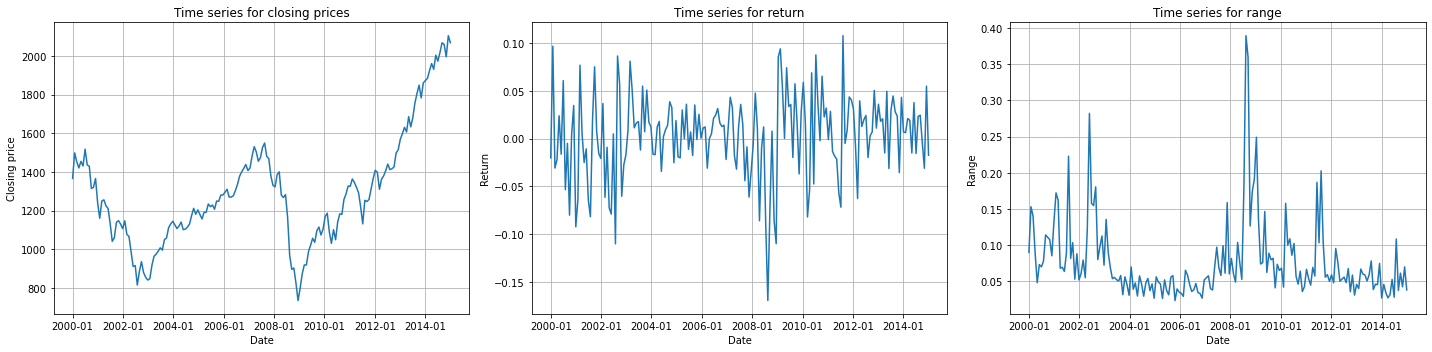

In [91]:
import matplotlib.dates as mdates
from datetime import datetime

n = len(st_closing_price) - 1
dates = pd.date_range(start='2000', end='2015.25', periods=n)

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

axs[0].plot(dates, st_closing_price[1:])
axs[0].set_title('Time series for closing prices')
axs[0].grid()
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Closing price')
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

axs[1].plot(dates, st_return[1:])
axs[1].set_title('Time series for return')
axs[1].grid()
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Return')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

axs[2].plot(dates, st_range[1:])
axs[2].set_title('Time series for range')
axs[2].grid()
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Range')
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()


3.2.2

In [92]:
class HMM:
    """struct holding the parameters of the Hidden Markov Model"""
    """:param n_states: number of hidden states (clusters)"""
    """:param prior: initial distribution (pi)"""
    """:param A: transition matrix"""
    """:param n_dims: dimension of observations"""
    """:param mu: emission probability means for each cluster"""
    """:param sigma: emission probability covariance matrix for each cluster"""
    
    def __init__(self, n_states):
        """:param n_states: number of hidden states (K)"""
        self.n_states = n_states
        self.random_state = np.random.RandomState(0)
        
        #Normalize random initial state
        self.prior = normalize(self.random_state.rand(self.n_states, 1))
        self.A = normalize(self.random_state.rand(self.n_states, self.n_states))
        
        self.mu = None
        self.sigma = None
        self.n_dims = None
        
def initialise(model, obs):
    """initialises the parameters of the HMM from some observations"""
    if model.n_dims is None:
        model.n_dims = obs.shape[0]
        #print(model.n_dims)
    if model.mu is None:
        subset = model.random_state.choice(np.arange(model.n_states), size=model.n_states, replace=False)
        #print(subset)
        model.mu = np.transpose(obs[:, subset])
        #print(model.mu)
    if model.sigma is None:
        model.sigma = np.zeros((model.n_states, model.n_dims, model.n_dims))
        model.sigma += np.diag(np.diag(np.cov(obs)))[None, :, :]
        
def normalize(x):
    """Normalises vectors and matrices"""
    temp = x
    if len(x.shape)>1:
        for s in range(temp.shape[0]):
            temp[s,:] /= np.sum(temp[s,:])
        return temp
    else:
        return (x) / np.sum(x,0)

In [93]:
import scipy.stats as st
def compute_emission_probabilites(model, obs):
    #obs = np.atleast_2d(obs)
    B = np.zeros((model.n_states, obs.shape[1]))
    for s in range(model.n_states):
        B[s, :] = st.multivariate_normal.pdf(obs.T, mean=model.mu[s], cov=model.sigma[s], allow_singular=True) ### <- fill in
    return B   


def forwardbackward(model, B):
    """Implementation of the forward-backward algorithm"""
    """:param model: this is the HMM, emmission """
    """:param B: emission matrix """
    
    log_likelihood = 0.
    T = B.shape[1]
    
    # forward algorithm
    alpha = np.zeros(B.shape)
    for t in range(T):
        if t == 0:
            alpha[:, t] = B[:, t] * model.prior.ravel()
        else:
            alpha[:, t] = B[:, t] * np.dot(model.A.T, alpha[:, t - 1])

        alpha_sum = np.sum(alpha[:, t])
        alpha[:, t] /= alpha_sum
        log_likelihood = log_likelihood + np.log(alpha_sum)
    
    # backward algorithm
    beta = np.zeros(B.shape);
    beta[:, -1] = np.ones(B.shape[0])

    for t in range(T - 1)[::-1]:
        beta[:, t] = np.dot(model.A, (B[:, t + 1] * beta[:, t + 1]))
        beta[:, t] /= np.sum(beta[:, t])
        
    # smoothed solution
    gamma = np.zeros((model.n_states, T))
    for t in range(T):
        gamma[:, t] = alpha[:, t] * beta[:, t]  ### <- fill in   
    
    return log_likelihood, alpha, beta, gamma

def predict0(model, obs):
    """MAP of filtered cluster probabilities (hard clustering)"""
    B = compute_emission_probabilites(model, obs)
    T = B.shape[1]
    
    _, alpha, _, _ = forwardbackward(model,B)
        
    return np.argmax(alpha.T, axis=1)

def predict(model, obs):
    """MAP of smoothed cluster probabilities (hard clustering)"""
    B = compute_emission_probabilites(model, obs)
    T = B.shape[1]
    
    _, _, _, gamma = forwardbackward(model,B)
        
    return np.argmax(gamma.T, axis=1)


def em_step(model, obs): 
    """One step of the EM training for the HMM"""

    # initialise HMM if needed
    initialise(model,obs)

    obs = np.atleast_2d(obs)
    B = compute_emission_probabilites(model,obs)
    T = obs.shape[1]

    # evaluate forward and backward probabilities (E step)
    log_likelihood, alpha, beta, gamma = forwardbackward(model,B)

    #E-Step: update model        
    expected_prior = normalize(gamma[:, 0])        
    xi = np.zeros((model.n_states, model.n_states))
    for t in range(T - 1):
        xi += normalize(model.A * np.dot(alpha[:, t], (beta[:, t+1] * B[:, t + 1]).T))
    expected_A = normalize(xi)

    # M-Step: update mu and sigma              
    expected_mu = np.zeros((model.n_states, model.n_dims))
    expected_sigma = np.zeros((model.n_states, model.n_dims, model.n_dims))

    for s in range(model.n_states):
        weight = gamma[s,:]/(gamma[s,:].sum())            
        expected_mu[s] = (obs @ weight)
        expected_sigma[s] = np.cov(obs, aweights=weight, bias=True) ### <- fill in

    # update
    model.prior = expected_prior
    model.mu = expected_mu
    model.sigma = expected_sigma
    model.A = expected_A
    return log_likelihood

def train(hmm,X, max_iter=1000, error=1e-5):
    """Performs an EM step by updating all parameters"""
    mu_list = []
    sigma_list = []
    for m in range(max_iter):
        
        mu_list.append(1*hmm.mu)
        sigma_list.append(1*hmm.sigma)
        log_likelihood = em_step(hmm,X)
        
        if m > 2:
            mu_norm = np.linalg.norm(np.array(mu_list[-1]) - np.array(mu_list[-2])) / np.linalg.norm(np.array(mu_list[-2]))
            sigma_norm = np.linalg.norm(np.array(sigma_list[-1]) - np.array(sigma_list[-2])) / np.linalg.norm(np.array(sigma_list[-2]))
            if mu_norm < error and sigma_norm < error:
                print(f'Converged at {m}th iteration')
                break

In [94]:
obs = np.array([st_closing_price[1:], st_return[1:], st_range[1:]])
np.random.seed(12345)
hmm1 = HMM(3)
initialise(hmm1, obs)
train(hmm1,obs)

Converged at 32th iteration


In [95]:
mu1 = hmm1.mu
sigma1 = hmm1.sigma

num_states = sigma1.shape[-1]

# Stack the diagonal elements together
var1 = np.vstack([sigma1[:, i, i] for i in range(num_states)]).T


Text(0.5, 0.98, 'visualising the variance of the mixture components')

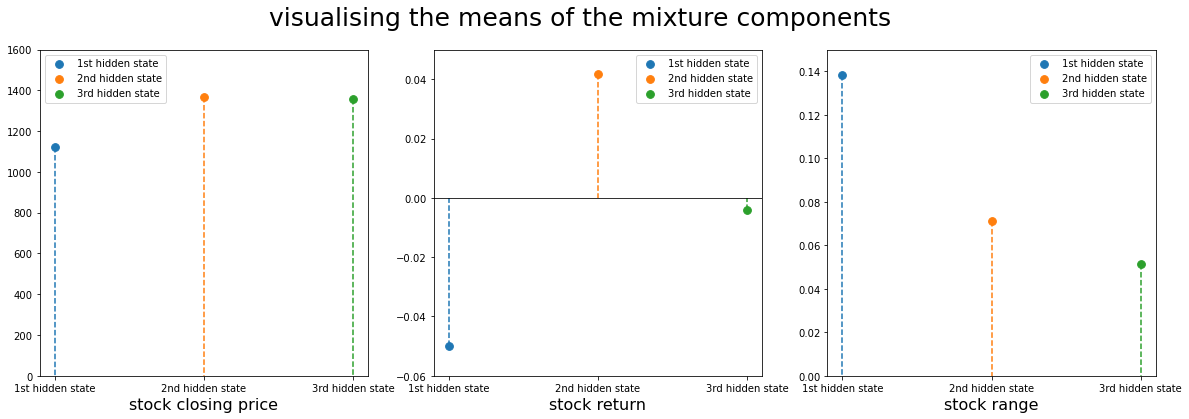

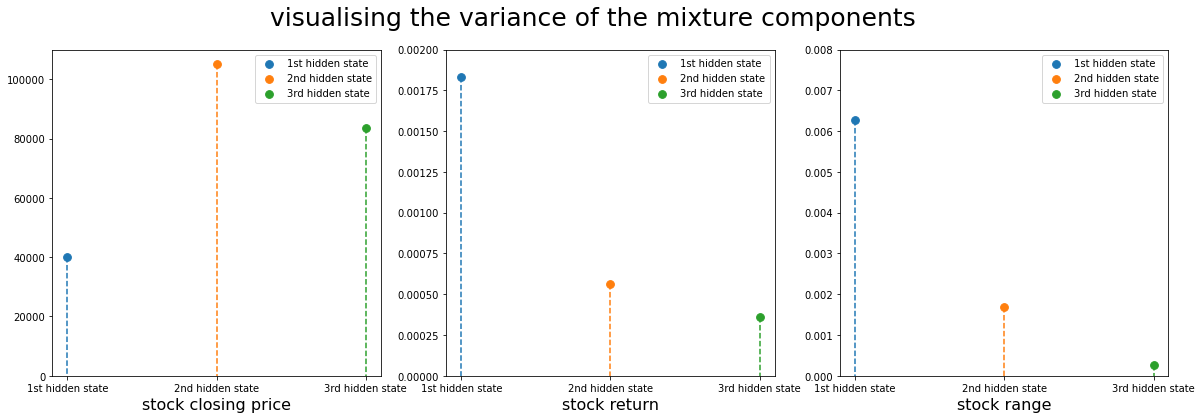

In [96]:
# define the figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# plot the first subplot
axs[0].scatter(1, mu1[0, 0], label='1st hidden state', s=60)
axs[0].plot([1, 1], [mu1[0, 0], 0], linestyle='--')
axs[0].scatter(2, mu1[1, 0], label='2nd hidden state', s=60)
axs[0].plot([2, 2], [mu1[1, 0], 0], linestyle='--')
axs[0].scatter(3, mu1[2, 0], label='3rd hidden state', s=60)
axs[0].plot([3, 3], [mu1[2, 0], 0], linestyle='--')
axs[0].set_xlabel('stock closing price', fontsize=16)
axs[0].set_ylim(0, 1600)
axs[0].legend()

# plot the second subplot
axs[1].scatter(1, mu1[0, 1], label='1st hidden state', s=60)
axs[1].plot([1, 1], [mu1[0, 1], 0], linestyle='--')
axs[1].scatter(2, mu1[1, 1], label='2nd hidden state', s=60)
axs[1].plot([2, 2], [mu1[1, 1], 0], linestyle='--')
axs[1].scatter(3, mu1[2, 1], label='3rd hidden state', s=60)
axs[1].plot([3, 3], [mu1[2, 1], 0], linestyle='--')
axs[1].axhline(0, color='black', linewidth=0.8)
axs[1].set_xlabel('stock return', fontsize=16)
axs[1].set_ylim(-0.06, 0.05)
axs[1].legend()

# plot the third subplot
axs[2].scatter(1, mu1[0, 2], label='1st hidden state', s=60)
axs[2].plot([1, 1], [mu1[0, 2], 0], linestyle='--')
axs[2].scatter(2, mu1[1, 2], label='2nd hidden state', s=60)
axs[2].plot([2, 2], [mu1[1, 2], 0], linestyle='--')
axs[2].scatter(3, mu1[2, 2], label='3rd hidden state', s=60)
axs[2].plot([3, 3], [mu1[2, 2], 0], linestyle='--')
axs[2].set_xlabel('stock range', fontsize=16)
axs[2].set_ylim(0, 0.15)
axs[2].legend()

axs[0].set_xticks([1, 2, 3])
axs[0].set_xticklabels(['1st hidden state', '2nd hidden state', '3rd hidden state'])
axs[1].set_xticks([1, 2, 3])
axs[1].set_xticklabels(['1st hidden state', '2nd hidden state', '3rd hidden state'])
axs[2].set_xticks([1, 2, 3])
axs[2].set_xticklabels(['1st hidden state', '2nd hidden state', '3rd hidden state'])


fig.suptitle('visualising the means of the mixture components', size = 25)

# define the figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

# plot the first subplot
axs[0].scatter(1, var1[0, 0], label='1st hidden state', s=60)
axs[0].plot([1, 1], [var1[0, 0], 0], linestyle='--')
axs[0].scatter(2, var1[1, 0], label='2nd hidden state', s=60)
axs[0].plot([2, 2], [var1[1, 0], 0], linestyle='--')
axs[0].scatter(3, var1[2, 0], label='3rd hidden state', s=60)
axs[0].plot([3, 3], [var1[2, 0], 0], linestyle='--')
axs[0].set_xlabel('stock closing price', fontsize=16)
axs[0].set_ylim(0, 110000)
axs[0].legend()

# plot the second subplot
axs[1].scatter(1, var1[0, 1], label='1st hidden state', s=60)
axs[1].plot([1, 1], [var1[0, 1], 0], linestyle='--')
axs[1].scatter(2, var1[1, 1], label='2nd hidden state', s=60)
axs[1].plot([2, 2], [var1[1, 1], 0], linestyle='--')
axs[1].scatter(3, var1[2, 1], label='3rd hidden state', s=60)
axs[1].plot([3, 3], [var1[2, 1], 0], linestyle='--')
axs[1].set_xlabel('stock return', fontsize=16)
axs[1].set_ylim(0, 0.0020)
axs[1].legend()

# plot the third subplot
axs[2].scatter(1, var1[0, 2], label='1st hidden state', s=60)
axs[2].plot([1, 1], [var1[0, 2], 0], linestyle='--')
axs[2].scatter(2, var1[1, 2], label='2nd hidden state', s=60)
axs[2].plot([2, 2], [var1[1, 2], 0], linestyle='--')
axs[2].scatter(3, var1[2, 2], label='3rd hidden state', s=60)
axs[2].plot([3, 3], [var1[2, 2], 0], linestyle='--')
axs[2].set_xlabel('stock range', fontsize=16)
axs[2].set_ylim(0, 0.008)
axs[2].legend()
axs[0].set_xticks([1, 2, 3])
axs[0].set_xticklabels(['1st hidden state', '2nd hidden state', '3rd hidden state'])
axs[1].set_xticks([1, 2, 3])
axs[1].set_xticklabels(['1st hidden state', '2nd hidden state', '3rd hidden state'])
axs[2].set_xticks([1, 2, 3])
axs[2].set_xticklabels(['1st hidden state', '2nd hidden state', '3rd hidden state'])

fig.suptitle('visualising the variance of the mixture components', size = 25)

State 1: High Volatility Downturn
This state is characterized by a relatively lower average closing price compared to the other two states and may characterize by rapidly dropping stock prices, high negative returns, and high volatility. The high negative returns indicate that the closing prices are dropping significantly compared to the previous month. The market is in a bearish or downturn phase, and investors may experience significant losses during this period. Using red as a color representation emphasizes the negative price movement and the potential risks associated with this state.

State 2: Moderate Volatility Upturn
State 2 has the highest average closing price among the three states, and it indicates an increasing trend for the closing price. The stock prices are generally increasing, although the change is less significant than in State 1. The market is in a bullish or mark-up phase, and investors may benefit from the positive price movement during this period. Using green as a color representation highlights the upward trend and the potential gains associated with this state.

State 3: Low Volatility Distribution
This state shows a small decreasing trend for the closing price, and it has the least dramatic change in closing price within the monthly period and represents a period of stability in the market, with stock prices fluctuating mildly around a relatively high level. The volatility is low, indicating that price changes are less dramatic compared to the other two states. The market is in a distribution or consolidation phase, and investors may choose to hold their positions or reallocate their assets for better returns during this period. Using light blue as a color representation conveys the stable and less volatile nature of this state.

3.2.3

In [97]:
def plot_hmm(model, X, i, label=True, ax=None):
    plt.figure(figsize=(12, 6))
    ax = ax or plt.gca()
    if label:
        labels = predict(model,X.T)
        ax.plot(np.linspace(2000, 2015.25, n), X[:, i])
        scatter = ax.scatter(np.linspace(2000, 2015.25, n), X[:, i], c=labels, s=40, cmap='viridis', zorder=2)
        ax.legend(handles=scatter.legend_elements()[0], labels = ["State 1","State 2","State 3"])
        ax.grid(True)
    else:
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=40, zorder=2)



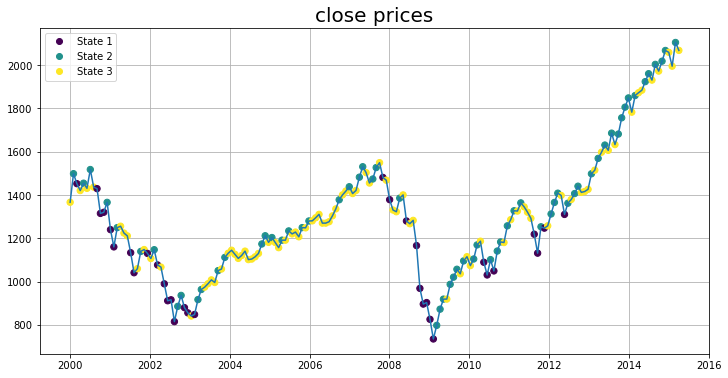

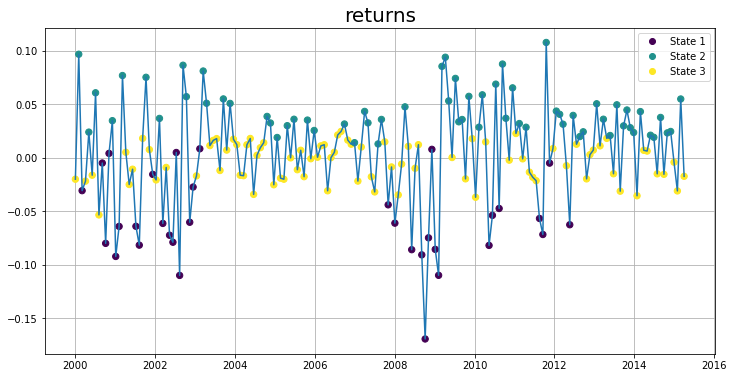

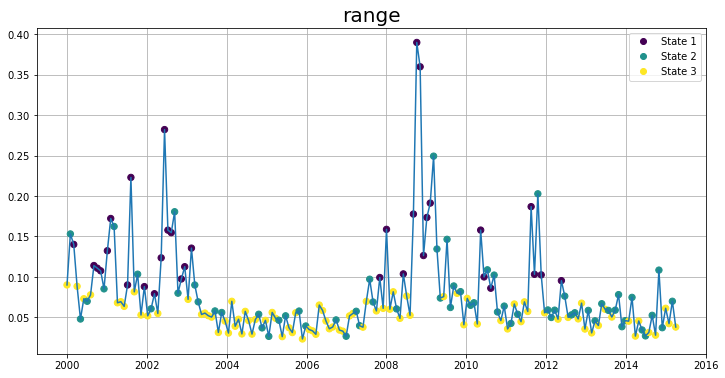

In [98]:
plot_hmm(hmm1,obs.T, 0)
plt.title("close prices", size=20);

plot_hmm(hmm1,obs.T, 1)
plt.title("returns", size=20);

plot_hmm(hmm1,obs.T, 2)
plt.title("range", size=20);

3.2.4

$$\mathrm {AIC} \,=\,2k-2\ln({\hat {L}})$$

In [99]:
def AIC(k, likelihood):
    
    return 2*k - 2* likelihood

k_list = np.arange(1,11,1)
aic_list = []
like_list = []
for k in k_list:
    np.random.seed(12345)
    hmm = HMM(k)
    initialise(hmm, obs)
    train(hmm,obs)
    b = compute_emission_probabilites(hmm, obs)
    like, alpha, beta, gamma = forwardbackward(hmm, b)
    aic = AIC(k, like)
    like_list.append(like)
    aic_list.append(aic)

Converged at 3th iteration
Converged at 21th iteration
Converged at 32th iteration
Converged at 52th iteration
Converged at 80th iteration
Converged at 84th iteration
Converged at 228th iteration
Converged at 384th iteration
Converged at 131th iteration
Converged at 137th iteration


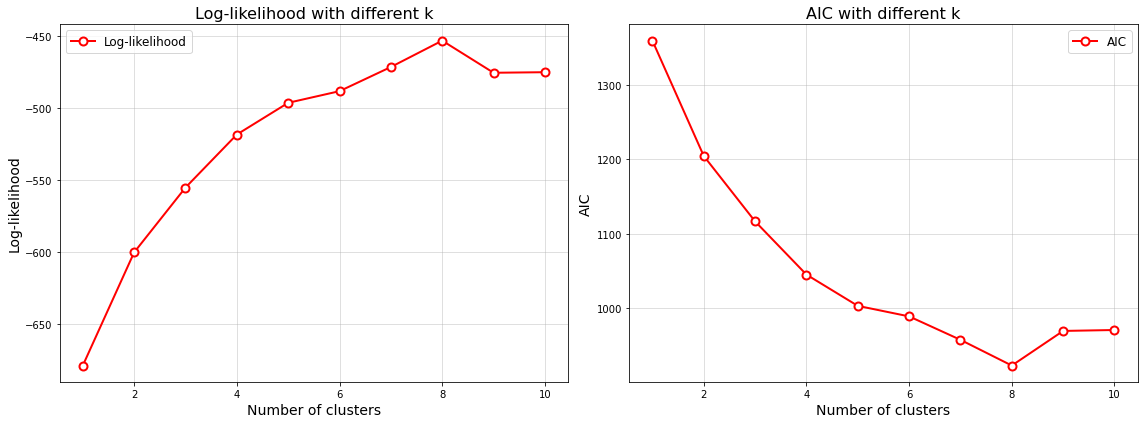

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# plot likelihood vs. number of clusters
axs[0].plot(k_list, like_list, color='red', lw=2, marker='o', markersize=8, markerfacecolor='white', markeredgewidth=2, label='Log-likelihood')
axs[0].set_xlabel('Number of clusters', fontsize=14)
axs[0].set_ylabel('Log-likelihood', fontsize=14)
axs[0].set_title('Log-likelihood with different k', fontsize=16)
axs[0].legend(fontsize=12, loc='upper left')
axs[0].grid(alpha=0.5)

# plot AIC vs. number of clusters
axs[1].plot(k_list, aic_list, color='red', lw=2, marker='o', markersize=8, markerfacecolor='white', markeredgewidth=2, label='AIC')
axs[1].set_xlabel('Number of clusters', fontsize=14)
axs[1].set_ylabel('AIC', fontsize=14)
axs[1].set_title('AIC with different k', fontsize=16)
axs[1].legend(fontsize=12, loc='upper right')
axs[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()


Here we find the best k is 8.

In [101]:
best_k = 8
np.random.seed(12345)
hmm2 = HMM(best_k)
initialise(hmm2, obs)
train(hmm2,obs)

Converged at 384th iteration


In [102]:
n = len(st_closing_price)-1

def plot_hmm2(model, X, i, label=True, ax=None):
    plt.figure(figsize=(12, 6))
    ax = ax or plt.gca()
    if label:
        labels = predict(model,X.T)
        ax.plot(np.linspace(2000, 2015.25, n), X[:, i])
        scatter = ax.scatter(np.linspace(2000, 2015.25, n), X[:, i], c=labels, s=40, cmap='viridis', zorder=2)
        ax.legend(handles=scatter.legend_elements()[0], labels = ["State 1","State 2","State 3", "State 4", "State 5", "State 6", "State 7", "State 8"], fontsize=12, loc="upper left")
        ax.set_title(f"State {i+1} Closing Price of Stock", fontsize=18)
        ax.set_xlabel("Year", fontsize=14)
        ax.tick_params(labelsize=12)
        ax.grid(True)
    else:
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=40, zorder=2)


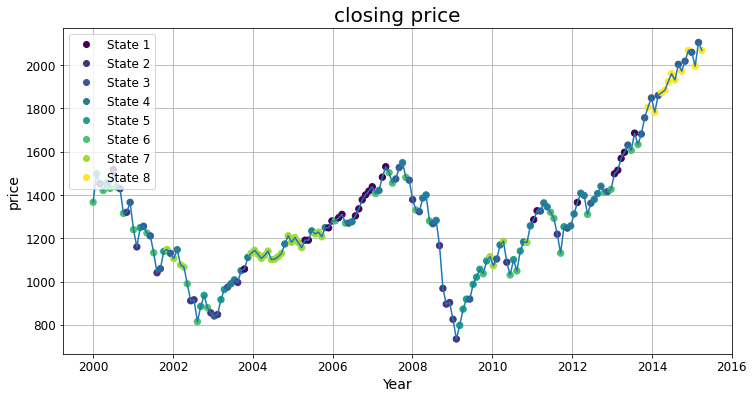

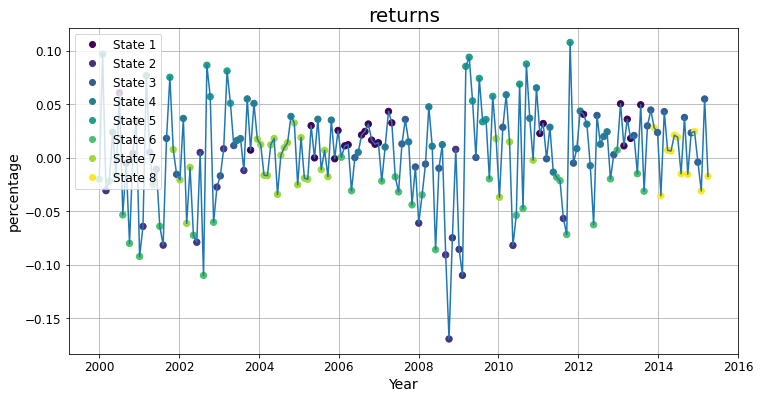

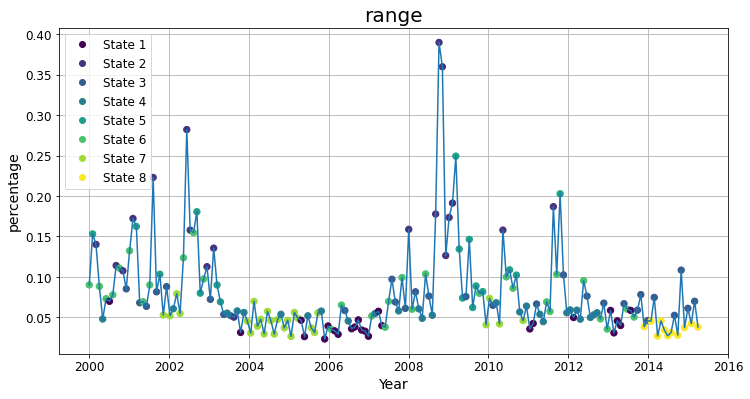

In [103]:
plot_hmm2(hmm2,obs.T, 0)
plt.ylabel('price', size=14)
plt.title("closing price", size=20);

plot_hmm2(hmm2,obs.T, 1)
plt.ylabel('percentage', size=14)
plt.title("returns", size=20);

plot_hmm2(hmm2,obs.T, 2)
plt.ylabel('percentage', size=14)
plt.title("range", size=20);

3.2.5

In [104]:
# Convert the 'Month' column to a pandas datetime object
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m')
# Consider only data before August 2007
df2 = df[df['Date'] < pd.to_datetime('200708', format='%Y%m')]

st_closing_price_2 = df2[['Adj Close**']].to_numpy().flatten()
st_closing_price_2 = st_closing_price_2[::-1]

st_return_2 = (st_closing_price_2[1:]/st_closing_price_2[:len(st_closing_price_2)-1] - 1)
st_return_2 = np.insert(st_return_2, 0, 0)

st_range_2 = (df2[['High']].to_numpy().flatten() - df2[['Low']].to_numpy().flatten()) / (df2[['Low']].to_numpy().flatten())
st_range_2 = st_range_2[::-1]
df2 

,Date,Open,High,Low,Close*,Adj Close**,Volume,range,return
91,2007-07-31,1455.18,1503.89,1370.60,1473.99,1473.99,91381760000,0.097249,0.012864
92,2007-06-30,1504.66,1555.90,1454.25,1455.27,1455.27,70337430000,0.069097,0.035794
93,2007-05-31,1530.62,1540.56,1484.18,1503.35,1503.35,65322800000,0.058091,0.014822
94,2007-04-30,1482.37,1535.56,1476.70,1530.62,1530.62,64958050000,0.099346,-0.044043
95,2007-03-31,1420.83,1498.02,1416.37,1482.37,1482.37,57032470000,0.061241,-0.008628
...,...,...,...,...,...,...,...,...,...
178,2000-04-30,1452.43,1481.51,1361.09,1420.60,1420.60,19898300000,0.037356,0.024534
179,2000-04-01,1498.58,1527.19,1339.40,1452.43,1452.43,20106460000,0.061337,-0.004189
180,2000-03-01,1366.42,1552.87,1346.62,1498.58,1498.58,26156200000,0.042372,-0.031041
181,2000-02-01,1394.46,1444.55,1325.07,1366.42,1366.42,20912000000,0.070014,0.054893


In [105]:
obs_true = obs.T[91:115].T
obs2 = np.array([st_closing_price_2[1:], st_return_2[1:], st_range_2[1:]])

In [106]:
np.random.seed(8)
hmm3 = HMM(8)
initialise(hmm3,obs2)
train(hmm3,obs2)

In [107]:
def forecast_hmm2(hmm, X, num_samples=10, num_steps=24):
    """Forecasts the time series using the HMM"""
    obs = 1 * X  # Consider data before August 2007
    state_sequences = [predict(hmm, obs)]
    
    # Initialize an array to store the generated observations
    all_obs = np.zeros((num_samples, hmm.n_dims, num_steps))

    # Sample from the model to generate predicted observations
    for i in range(num_samples):
        state_sequence = state_sequences[-1]
        obs = np.zeros((hmm.n_dims, num_steps))
        obs[:, 0] = np.random.multivariate_normal(hmm.mu[state_sequence[-1]], hmm.sigma[state_sequence[-1]])
        for t in range(1, num_steps):
            state = np.random.choice(hmm.n_states, p=hmm.A[state_sequence[-1], :])
            obs[:, t] = np.random.multivariate_normal(hmm.mu[state], hmm.sigma[state])
            state_sequence = np.append(state_sequence[1:], state)
        state_sequences.append(state_sequence)
        
        # Store the generated observations
        all_obs[i] = obs

    # Calculate the mean of the observations across all samples
    mean_obs = np.mean(all_obs, axis=0)

    return mean_obs, np.array(state_sequences[1:])


In [108]:
obs_pred, state_sequences= forecast_hmm2(hmm3, obs2, num_samples=10, num_steps=24)
obs_pred.shape

(3, 24)

In [109]:
n = len(obs_pred.T)
def plot_hmm3(model, X, X_true, i, label=True, ax=None):
    plt.figure(figsize=(12, 6))
    ax = ax or plt.gca()
    if label:
        labels = predict(model,X.T)
        ax.plot(np.linspace(0, 4, n), X[:, i], label = 'forcast')
        ax.plot(np.linspace(0, 4, n), X_true[:, i], label = 'true')
        scatter = ax.scatter(np.linspace(0, 4, n), X[:, i], c=labels, s=40, cmap='viridis', zorder=2)
        ax.set_xticks([0, 1, 2, 3, 4])
        ax.set_xticklabels(['Jul 2007', 'Dec 2007', 'Jul 2008', 'Dec 2008', 'Jul 2009'])
        ax.legend()
        ax.grid(True)
    else:
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=40, zorder=2)

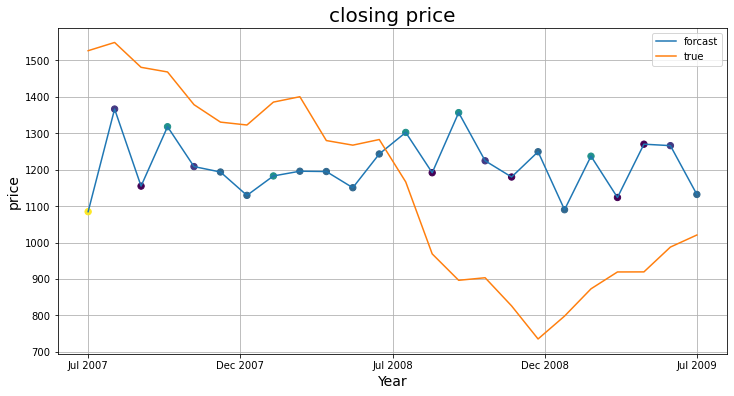

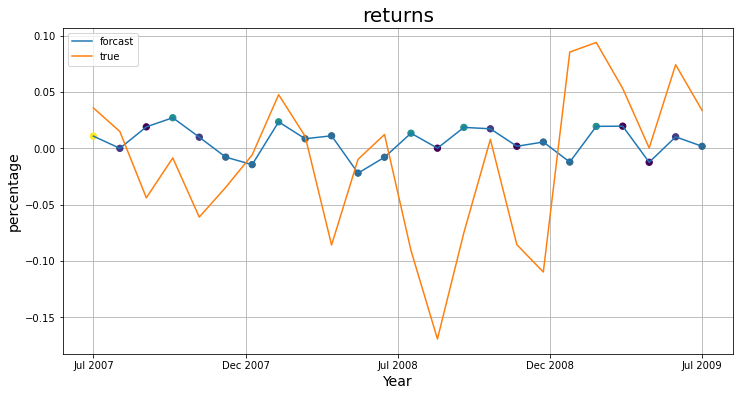

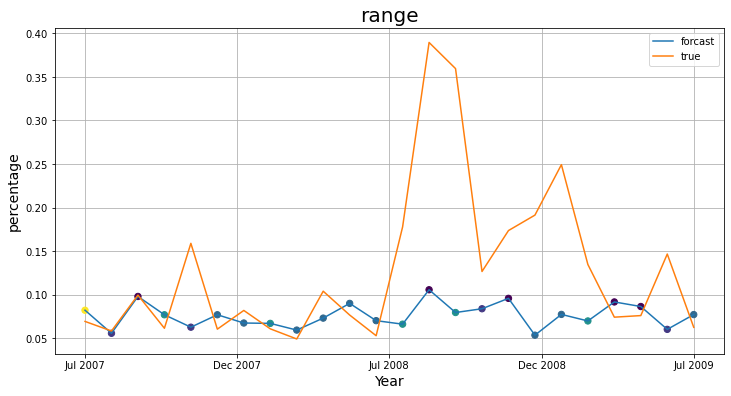

In [110]:
plot_hmm3(hmm3,obs_pred.T, obs_true.T, 0)
plt.xlabel('Year', size=14)
plt.ylabel('price', size=14)
plt.title("closing price", size=20);

plot_hmm3(hmm3,obs_pred.T, obs_true.T, 1)
plt.xlabel('Year', size=14)
plt.ylabel('percentage', size=14)
plt.title("returns", size=20);

plot_hmm3(hmm3,obs_pred.T, obs_true.T, 2)
plt.xlabel('Year', size=14)
plt.ylabel('percentage', size=14)
plt.title("range", size=20);

In [111]:
mse_close = np.mean((obs_pred.T[:,0] - obs_true.T[:,0]) ** 2)
mse_return = np.mean((obs_pred.T[:,1] - obs_true.T[:,1]) ** 2)
mse_range = np.mean((obs_pred.T[:,2] - obs_true.T[:,2]) ** 2)
rmse_close = np.sqrt(mse_close)
rmse_return = np.sqrt(mse_return)
rmse_range = np.sqrt(mse_range)
mae_close = np.mean(np.abs(obs_pred.T[:,0] - obs_true.T[:,0]))
mae_return = np.mean(np.abs(obs_pred.T[:,1] - obs_true.T[:,1]))
mae_range = np.mean(np.abs(obs_pred.T[:,2] - obs_true.T[:,2]))

In [112]:
print(mse_close, mse_return, mse_range)
print(rmse_close, rmse_return, rmse_range)
print(mae_close, mae_return, mae_range)

74767.16120285429 0.0047211233275715435 0.01051910783525911
273.43584476592366 0.06871043099538485 0.10256270196937632
244.21669294497 0.053936510071851275 0.06412900588368953


The model in some way failed to predict the disastrous financial crisis in 2008. The large MSE, RMSE, MAE values indicate that the model's performance was quite poor in predicting the actual stock prices.

However, the model does provide some warning about the pre-crisis price being higher than the normal level and predicts it to drop. While not an accurate representation of the magnitude of the crisis, this information can still serve as an early alert for investors to consider exiting the market.

The limitations of the HMM model in predicting the 2008 financial crisis can be attributed to the Markov assumption, which states that the current state depends only on the previous state and not on any other previous states. This assumption may not be sufficient to capture the long-term memory and dependencies present in financial time series data, which can influence future events. In the context of the 2008 financial crisis, the HMM model failed to account for the complex interactions and dependencies among various factors that led to the crisis, such as global economic imbalances, excessive risk-taking, and failures in financial market regulation. These factors are not easily captured by the simple Markov assumption, resulting in the model's inability to predict the magnitude and volatility of the crisis accurately.

In conclusion, while HMMs can be useful for modeling and predicting certain trends and behaviors in financial time series data, they have limitations in capturing the complexity of real-world financial markets. The Markov assumption can be a restricting factor in accurately predicting rare and complex events such as the 2008 financial crisis. It is essential to consider these limitations when using HMMs for financial forecasting and to explore alternative models or techniques that can better capture the underlying dynamics of financial markets.